## Compose

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

from sim.netrual import Component, NLT_reserve, NLT_components, NLT_accounts, NLT_REWARD  # noqa
from sim.data import get_batch_price, get_price, read_csv, format_ts as t
import pandas as pd
target = ['EOS', 'MANA', 'OMG', 'ARK', 'BNB', 'IOTA', 'ETH']
market_prices = get_batch_price(target)
m = market_prices.dropna()


In [2]:
# get_price('EOS')
m.describe()

,EOS,timestamp,MANA,OMG,ARK,BNB,IOTA,ETH
count,11022.000000,1.102200e+04,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000
mean,1.012053,1.504604e+12,0.065702,9.082596,3.162795,1.521508,0.459192,307.204804
std,0.334062,9.635453e+08,0.037275,1.075108,0.565987,0.709074,0.096970,37.771487
min,0.482895,1.502942e+12,0.013272,6.526780,1.481956,0.503544,0.301110,193.100000
25%,0.679737,1.503767e+12,0.017794,8.205073,2.866501,0.855845,0.408065,283.010000
50%,0.956240,1.504592e+12,0.078798,8.915736,3.124290,1.250860,0.448055,301.225000
75%,1.338159,1.505443e+12,0.097047,9.852690,3.413848,2.201847,0.497293,331.245000
max,1.583040,1.506267e+12,0.140380,13.793944,5.206336,2.956131,7.532500,394.320000


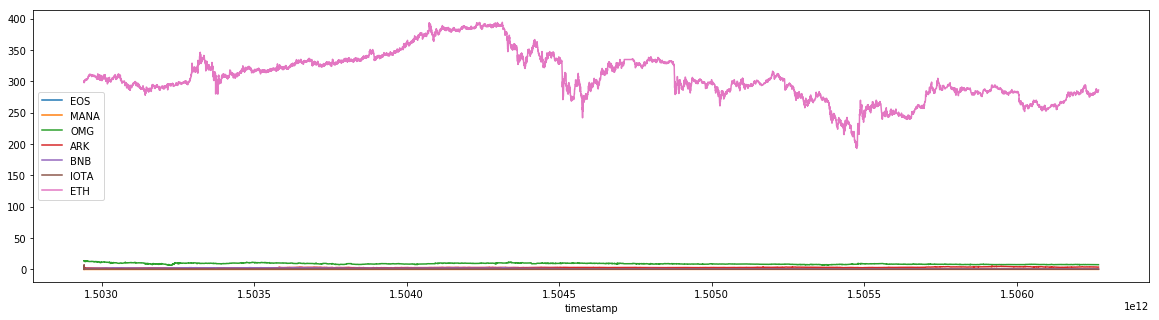

In [3]:
m.plot(x='timestamp', figsize=(20, 5))

In [4]:
tokens = [t for t in market_prices.columns if t != 'timestamp']
[Component(t) for t in tokens] 

[0.0 EOS => 0 NTL,
 0.0 MANA => 0 NTL,
 0.0 OMG => 0 NTL,
 0.0 ARK => 0 NTL,
 0.0 BNB => 0 NTL,
 0.0 IOTA => 0 NTL,
 0.0 ETH => 0 NTL]

### Warmup with rational auction on fixed price

In [5]:
def rational_warmup(timestamp, market_price, sender, inital_price):
    for c in NLT_components.values():
        res = c(timestamp).auction(sender, (float(inital_price) / float(market_price[c.token])) * NLT_REWARD)
        print(res)

In [6]:
def warmup(p=15):
    mp = m.T[0].drop('timestamp')
    start_time = t(m.T[0]['timestamp']) - Component.auction_window - 1
    sender = 'satoshi'
    inital_price = float(p)  # 15 USD
    rational_warmup(start_time, mp, sender, inital_price)
    [c(m.T[0].timestamp) for c in NLT_components.values()]

\begin{gather*}
\mathbb{P}_{auction_t} = \frac{\mathbb{P}_{target}}{\mathbb{P}_{market}} \times 1000 \\
t = Time_{current} - Time_{window}
\end{gather*}

### Price via highest components $P_h$.

\begin{gather*}
\frac{Highest(Price_{components}) \times min_{bid}(Highest(Price_{components}))}{1000} \ for\ each\ components
\end{gather*}

### Price via average auction bid $P_a$.

\begin{gather*}
\frac{\sum{component_{highest\ bid}\times component_{price}}}{NLT_{amount\ per\ round}}
\end{gather*}




In [7]:
from sim.utils import nlt_price as p_h, nlt_price_3 as p_a

In [8]:
from sim.utils import determin_auction_quantity, determin_redeem_quantity
from sim.utils import redeem_strategy as redeem, auction_strategy as auction

In [9]:
def simulator(a_t, r_t, s_r):
    ret = []
    for i, data in market_prices.iterrows():
        current = i
        print("==" * 10)
        print('round %s' % i)
        if i > s_r:
            plan_to_redeem = determin_redeem_quantity(data.drop('timestamp'), p_a, threshold=r_t)
            print('plan to redeem %s' % plan_to_redeem)
            redeem(plan_to_redeem, 'satoshi', data.timestamp)
        plan_to_auction = determin_auction_quantity(data.drop('timestamp'), p_a, threshold=a_t)
        auction(plan_to_auction, 'satoshi', data.timestamp)
        print('plan to auction %s' % plan_to_auction)

        ret.append(dict({
            'timestamp': data.timestamp,
            'price': p_a(data),
        }, **NLT_reserve))
    return pd.DataFrame(ret)


In [10]:

warmup(15)

True
True
True
True
True
True
True
EOS:: New cycle 1 <- 0
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 10000}
MANA:: New cycle 1 <- 0
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 20000}
OMG:: New cycle 1 <- 0
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 30000}
ARK:: New cycle 1 <- 0
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 40000}
BNB:: New cycle 1 <- 0
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 50000}
IOTA:: New cycle 1 <- 0
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 60000}
ETH:: New cycle 1 <- 0
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 70000}


In [11]:
p_a(m.T[1]) # p_a

17.319626192963124

In [12]:
NLT_components

{'ARK': 100997.17881213852 ARK => 70000 NTL,
 'BNB': 112121.59558816794 BNB => 70000 NTL,
 'EOS': 94754.3720630606 EOS => 70000 NTL,
 'ETH': 498.12373393550956 ETH => 70000 NTL,
 'IOTA': 498156.81976686255 IOTA => 70000 NTL,
 'MANA': 9280799.881205762 MANA => 70000 NTL,
 'OMG': 10952.577900593658 OMG => 70000 NTL}

In [13]:
determin_redeem_quantity(m.T[1000].drop('timestamp'), p_a)

{'ARK': 1, 'BNB': 1, 'EOS': 1, 'ETH': 401, 'MANA': 1, 'OMG': 1}

In [14]:
res = simulator(0.1, 0.1, 2000)

round 0
plan to auction {}
round 1
plan to auction {'EOS': 110304.70864129385, 'OMG': 13196.699584276039, 'ARK': 116615.55890467296, 'BNB': 131671.8305359976, 'ETH': 581.1955098309772}
round 2
plan to auction {'EOS': 425046.2967692564, 'MANA': 35765750.44923605, 'OMG': 49669.26484030218, 'ARK': 449917.6928637713, 'BNB': 504625.4640287978, 'ETH': 2237.4437061933654}
round 3
plan to auction {'EOS': 124034.57116326278, 'MANA': 11148756.505169626, 'OMG': 14695.678697169673, 'BNB': 147024.63720963226, 'ETH': 655.150604884354}
round 4
plan to auction {'EOS': 146747.9764957249, 'MANA': 13203316.98365841, 'OMG': 17408.111656311554, 'BNB': 173618.307631043, 'ETH': 773.6553320854616}
round 5
plan to auction {'EOS': 123579.6942056996, 'MANA': 11400481.106713697, 'OMG': 14984.206176645635, 'BNB': 146997.17197171095, 'ETH': 651.3885681582426}
round 6
plan to auction {'EOS': 134206.4484686947, 'MANA': 12348570.752105992, 'OMG': 16273.849931471286, 'BNB': 158886.8052662233, 'ETH': 707.4021898784898}


plan to auction {}
round 113
plan to auction {}
round 114
plan to auction {}
round 115
plan to auction {}
round 116
plan to auction {}
round 117
plan to auction {}
round 118
plan to auction {}
round 119
plan to auction {}
round 120
plan to auction {}
round 121
plan to auction {}
round 122
plan to auction {}
round 123
plan to auction {}
round 124
plan to auction {}
round 125
plan to auction {}
round 126
plan to auction {}
round 127
plan to auction {}
round 128
plan to auction {}
round 129
plan to auction {}
round 130
plan to auction {}
round 131
plan to auction {}
round 132
plan to auction {}
round 133
plan to auction {}
round 134
plan to auction {}
round 135
plan to auction {}
round 136
plan to auction {}
round 137
plan to auction {}
round 138
plan to auction {}
round 139
plan to auction {}
round 140
plan to auction {}
round 141
plan to auction {}
round 142
plan to auction {}
round 143
plan to auction {}
round 144
plan to auction {}
round 145
plan to auction {}
round 146
plan to auctio

plan to auction {}
round 325
plan to auction {}
round 326
plan to auction {}
round 327
plan to auction {}
round 328
plan to auction {}
round 329
plan to auction {}
round 330
plan to auction {}
round 331
plan to auction {}
round 332
plan to auction {}
round 333
plan to auction {}
round 334
IOTA:: New cycle 28 <- 27
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 200000}
plan to auction {'IOTA': 743515.784144618}
round 335
plan to auction {}
round 336
plan to auction {}
round 337
plan to auction {}
round 338
plan to auction {}
round 339
plan to auction {}
round 340
plan to auction {}
round 341
plan to auction {}
round 342
plan to auction {}
round 343
plan to auction {}
round 344
plan to auction {}
round 345
plan to auction {}
round 346
plan to auction {}
round 347
plan to auction {}
round 348
plan to auction {}
round 349
plan to auction {}
round 350
plan to auction {}
round 351
plan to auction {}
round 352
plan to auction {}
round 353
plan to auction {}
round 354


plan to auction {}
round 537
plan to auction {}
round 538
plan to auction {}
round 539
plan to auction {}
round 540
plan to auction {}
round 541
plan to auction {}
round 542
plan to auction {}
round 543
plan to auction {}
round 544
plan to auction {}
round 545
plan to auction {}
round 546
plan to auction {}
round 547
plan to auction {}
round 548
plan to auction {}
round 549
plan to auction {}
round 550
plan to auction {}
round 551
plan to auction {}
round 552
plan to auction {}
round 553
plan to auction {}
round 554
plan to auction {}
round 555
plan to auction {}
round 556
plan to auction {}
round 557
plan to auction {}
round 558
plan to auction {}
round 559
plan to auction {}
round 560
plan to auction {}
round 561
plan to auction {}
round 562
plan to auction {}
round 563
plan to auction {}
round 564
plan to auction {}
round 565
plan to auction {}
round 566
plan to auction {}
round 567
plan to auction {}
round 568
plan to auction {}
round 569
plan to auction {}
round 570
plan to auctio

plan to auction {}
round 755
plan to auction {}
round 756
plan to auction {}
round 757
IOTA:: New cycle 64 <- 63
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 260000}
plan to auction {'IOTA': 771450.3985569217}
round 758
plan to auction {'IOTA': 768188.0832387429}
round 759
plan to auction {'IOTA': 765113.1300790617}
round 760
plan to auction {'IOTA': 764781.182365153}
round 761
plan to auction {'IOTA': 763138.4487924224}
round 762
plan to auction {'IOTA': 761434.4330158681}
round 763
plan to auction {}
round 764
plan to auction {}
round 765
plan to auction {}
round 766
plan to auction {}
round 767
plan to auction {}
round 768
plan to auction {}
round 769
IOTA:: New cycle 65 <- 64
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 270000}
plan to auction {'IOTA': 763106.6370275605}
round 770
plan to auction {}
round 771
plan to auction {}
round 772
plan to auction {}
round 773
plan to auction {}
round 774
plan to auction {}
round 775
plan 

OMG:: New cycle 78 <- 77
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 320000}
plan to auction {'OMG': 58887.18188004696}
round 934
plan to auction {'OMG': 58698.13027577496}
round 935
plan to auction {'OMG': 59789.80708023047}
round 936
plan to auction {'OMG': 58909.3016434797}
round 937
OMG:: New cycle 79 <- 78
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 330000}
plan to auction {'OMG': 58881.83121375226}
round 938
plan to auction {}
round 939
plan to auction {}
round 940
plan to auction {'OMG': 60207.80427651276}
round 941
plan to auction {'OMG': 60267.516201362356}
round 942
plan to auction {}
round 943
plan to auction {}
round 944
plan to auction {'OMG': 60008.32272350436}
round 945
plan to auction {'OMG': 59822.82502691255}
round 946
plan to auction {'OMG': 60035.94425245681}
round 947
plan to auction {'OMG': 60150.119291835676}
round 948
plan to auction {'OMG': 61346.65770982887}
round 949
OMG:: New cycle 80 <- 79
Found last W

round 1076
plan to auction {}
round 1077
plan to auction {}
round 1078
plan to auction {}
round 1079
plan to auction {}
round 1080
plan to auction {}
round 1081
plan to auction {}
round 1082
plan to auction {}
round 1083
plan to auction {}
round 1084
plan to auction {}
round 1085
plan to auction {}
round 1086
plan to auction {}
round 1087
plan to auction {}
round 1088
plan to auction {}
round 1089
plan to auction {}
round 1090
plan to auction {}
round 1091
plan to auction {}
round 1092
plan to auction {}
round 1093
plan to auction {}
round 1094
plan to auction {}
round 1095
plan to auction {}
round 1096
plan to auction {}
round 1097
plan to auction {}
round 1098
plan to auction {}
round 1099
plan to auction {}
round 1100
plan to auction {}
round 1101
plan to auction {}
round 1102
plan to auction {}
round 1103
plan to auction {}
round 1104
plan to auction {}
round 1105
plan to auction {}
round 1106
plan to auction {}
round 1107
plan to auction {}
round 1108
plan to auction {}
round 1109

round 1243
plan to auction {}
round 1244
plan to auction {}
round 1245
plan to auction {}
round 1246
plan to auction {}
round 1247
plan to auction {}
round 1248
plan to auction {}
round 1249
plan to auction {}
round 1250
plan to auction {}
round 1251
plan to auction {}
round 1252
plan to auction {}
round 1253
plan to auction {}
round 1254
plan to auction {}
round 1255
plan to auction {}
round 1256
plan to auction {}
round 1257
plan to auction {}
round 1258
plan to auction {}
round 1259
plan to auction {}
round 1260
plan to auction {}
round 1261
plan to auction {}
round 1262
plan to auction {}
round 1263
plan to auction {}
round 1264
plan to auction {}
round 1265
plan to auction {}
round 1266
plan to auction {}
round 1267
plan to auction {}
round 1268
plan to auction {}
round 1269
plan to auction {}
round 1270
plan to auction {}
round 1271
plan to auction {}
round 1272
plan to auction {}
round 1273
plan to auction {}
round 1274
plan to auction {}
round 1275
plan to auction {}
round 1276

plan to auction {}
round 1410
plan to auction {}
round 1411
plan to auction {}
round 1412
plan to auction {}
round 1413
plan to auction {}
round 1414
plan to auction {}
round 1415
plan to auction {}
round 1416
plan to auction {}
round 1417
plan to auction {}
round 1418
plan to auction {}
round 1419
plan to auction {}
round 1420
plan to auction {}
round 1421
plan to auction {}
round 1422
plan to auction {}
round 1423
plan to auction {}
round 1424
plan to auction {}
round 1425
plan to auction {}
round 1426
plan to auction {}
round 1427
plan to auction {}
round 1428
plan to auction {}
round 1429
plan to auction {}
round 1430
plan to auction {}
round 1431
plan to auction {}
round 1432
plan to auction {}
round 1433
plan to auction {}
round 1434
plan to auction {}
round 1435
plan to auction {}
round 1436
plan to auction {}
round 1437
plan to auction {}
round 1438
plan to auction {}
round 1439
plan to auction {}
round 1440
plan to auction {}
round 1441
plan to auction {}
round 1442
plan to au

plan to auction {}
round 1609
plan to auction {}
round 1610
plan to auction {}
round 1611
plan to auction {}
round 1612
plan to auction {}
round 1613
plan to auction {}
round 1614
plan to auction {}
round 1615
plan to auction {}
round 1616
plan to auction {}
round 1617
plan to auction {}
round 1618
plan to auction {}
round 1619
plan to auction {}
round 1620
plan to auction {}
round 1621
plan to auction {}
round 1622
plan to auction {}
round 1623
plan to auction {}
round 1624
plan to auction {}
round 1625
plan to auction {}
round 1626
plan to auction {}
round 1627
plan to auction {}
round 1628
plan to auction {}
round 1629
plan to auction {}
round 1630
plan to auction {}
round 1631
plan to auction {}
round 1632
plan to auction {}
round 1633
plan to auction {}
round 1634
plan to auction {}
round 1635
plan to auction {}
round 1636
plan to auction {}
round 1637
plan to auction {}
round 1638
plan to auction {}
round 1639
plan to auction {}
round 1640
plan to auction {}
round 1641
plan to au

plan to auction {}
round 1833
plan to auction {}
round 1834
plan to auction {}
round 1835
plan to auction {}
round 1836
plan to auction {}
round 1837
plan to auction {}
round 1838
plan to auction {}
round 1839
plan to auction {}
round 1840
plan to auction {}
round 1841
plan to auction {}
round 1842
plan to auction {}
round 1843
plan to auction {}
round 1844
plan to auction {}
round 1845
IOTA:: New cycle 154 <- 99
plan to auction {'IOTA': 929627.842754907}
round 1846
plan to auction {'IOTA': 928505.332720363}
round 1847
plan to auction {'IOTA': 932602.1402188275}
round 1848
plan to auction {'IOTA': 928525.560349522}
round 1849
plan to auction {'IOTA': 926953.0105737416}
round 1850
plan to auction {'IOTA': 927149.7540396479}
round 1851
IOTA:: New cycle 155 <- 154
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 380000}
plan to auction {'IOTA': 930464.3104861641}
round 1852
plan to auction {}
round 1853
plan to auction {}
round 1854
plan to auction {}
round 1855
pla

plan to auction {'EOS': 332841.54861217877, 'MANA': 30739897.446539517, 'OMG': 42115.42836995929, 'ARK': 174650.07833542858, 'BNB': 173167.01326452915, 'IOTA': 876939.6282593067}
round 2024
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 330649.43232928973, 'MANA': 30678965.347428698, 'OMG': 42533.839740430136, 'ARK': 173472.28137219325, 'BNB': 171216.2375091734, 'IOTA': 877125.4807198588}
round 2025
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 332936.8943305626, 'MANA': 30634449.304925475, 'OMG': 42254.68563881047, 'ARK': 173743.97289672564, 'BNB': 173039.63969137892, 'IOTA': 877141.4576093977}
round 2026
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 331092.16336458916, 'MANA': 30489304.303883396, 'OMG': 42594.68230687862, 'ARK': 173823.71327032536, 'BNB': 172103.16364623877, 'IOTA': 875685.1575238486}
round 2027
plan to

round 2057
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 332568.693843924, 'MANA': 29506130.66711965, 'OMG': 42839.4779227924, 'ARK': 174997.12724193855, 'BNB': 172071.20947150193, 'IOTA': 890078.7177384996}
round 2058
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 333576.3631133416, 'MANA': 29614884.420450456, 'OMG': 42710.36510166834, 'ARK': 175095.2414705425, 'BNB': 173134.73170142103, 'IOTA': 887764.899331717}
round 2059
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 331275.7126730208, 'MANA': 29936658.373557586, 'OMG': 43139.151425881755, 'ARK': 174480.34267460066, 'BNB': 171719.36035802553, 'IOTA': 883963.0317653896}
round 2060
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 330375.0670221525, 'MANA': 29982938.36184414, 'OMG': 43110.76851117661, 'ARK': 174319.8071

Current balance {'satoshi': 996605}
plan to auction {'EOS': 332487.27830409235, 'MANA': 30327909.27628408, 'OMG': 42771.584949944336, 'ARK': 174753.498262187, 'BNB': 188259.6886613712, 'IOTA': 862838.7571207759}
round 2117
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 332642.73130636255, 'MANA': 30379107.922947884, 'OMG': 42900.51496328213, 'ARK': 175286.134562496, 'BNB': 183622.6512068712, 'IOTA': 868770.0215006878}
round 2118
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 330833.98297655385, 'MANA': 30294182.793725856, 'OMG': 42871.88522706804, 'ARK': 176052.33319096317, 'BNB': 184689.49451628534, 'IOTA': 868190.2462563217}
round 2119
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 332582.4764258953, 'MANA': 30423654.149513647, 'OMG': 42868.74269440836, 'ARK': 174554.72407127797, 'BNB': 184703.66066496738, 'IOTA': 868126.

plan to auction {'EOS': 339491.24604157795, 'MANA': 29408931.146652624, 'OMG': 44358.21606732774, 'ARK': 156735.7703501133, 'BNB': 201278.54673345556, 'IOTA': 879818.4429784104}
round 2188
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 183 <- 182
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1306178}
MANA:: New cycle 183 <- 182
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1316177}
OMG:: New cycle 183 <- 182
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1326176}
ARK:: New cycle 183 <- 182
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1336175}
BNB:: New cycle 183 <- 182
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1346174}
IOTA:: New cycle 183 <- 182
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1356173}
plan to auction {'EOS': 339121.06866969523, 'MANA': 29416196.05298957, 'OMG': 44379

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 342540.9332264996, 'MANA': 29109280.554962814, 'OMG': 47652.09056098286, 'ARK': 152710.59644514936, 'BNB': 198929.78178871848, 'IOTA': 863795.9075310198}
round 2227
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 342685.24977668066, 'MANA': 29115314.30905058, 'OMG': 47660.915554348125, 'ARK': 149798.55622916025, 'BNB': 201054.67009058438, 'IOTA': 869346.791560635}
round 2228
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 341112.23339485057, 'MANA': 29118654.508382156, 'OMG': 47613.01242864398, 'ARK': 150456.0300849448, 'BNB': 200659.54923831337, 'IOTA': 870516.6251419059}
round 2229
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 346718.1738834775, 'MANA': 29525426.696359888, 'OMG': 48498.001981052075, 'ARK': 139005.880779353

sent 10000 NTL to satoshi
Current balance {'satoshi': 1815599}
BNB:: New cycle 191 <- 190
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1825598}
IOTA:: New cycle 191 <- 190
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1835597}
plan to auction {'EOS': 352483.93744915037, 'MANA': 30118454.159771744, 'OMG': 49366.418410178565, 'ARK': 148973.99127640852, 'BNB': 180431.20964613554, 'IOTA': 886765.8319738186}
round 2285
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 348735.5369841386, 'MANA': 30025706.04554858, 'OMG': 49808.585386562445, 'ARK': 149217.11795695339, 'BNB': 180429.28045806623, 'IOTA': 887250.2773117817}
round 2286
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 349375.3193775403, 'MANA': 30080619.927223805, 'OMG': 49908.35772852077, 'ARK': 149611.6002541765, 'BNB': 178218.36967946647, 'IOTA': 889793.3826161792}
round 2

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 344789.99076407467, 'MANA': 29775386.383689288, 'OMG': 49919.29125825047, 'ARK': 148495.22072556982, 'BNB': 185631.4984751312, 'IOTA': 886725.7759752027}
round 2319
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 348223.45459805185, 'MANA': 30074548.27304952, 'OMG': 50113.29013570721, 'ARK': 145910.5220875366, 'BNB': 184268.21731962266, 'IOTA': 888984.3625504135}
round 2320
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 194 <- 193
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1965386}
MANA:: New cycle 194 <- 193
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1975385}
OMG:: New cycle 194 <- 193
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 1985384}
ARK:: New cycle 194 <- 193
Found last Winner
sent 10000 NTL to s

plan to auction {'EOS': 352585.4509124435, 'MANA': 30477337.848121278, 'OMG': 48333.94854857472, 'ARK': 136486.87000595458, 'BNB': 191115.48349083593, 'IOTA': 936136.1785614176}
round 2369
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 352734.88616219314, 'MANA': 30537278.494523443, 'OMG': 48205.2371032927, 'ARK': 136744.20504366793, 'BNB': 190885.8992396341, 'IOTA': 935934.8930334572}
round 2370
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 351486.5200964449, 'MANA': 30783818.038603976, 'OMG': 48685.96369116937, 'ARK': 135821.8147007778, 'BNB': 193176.5076307419, 'IOTA': 922490.9468105854}
round 2371
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 353104.728160865, 'MANA': 30661031.323181182, 'OMG': 48741.950371273015, 'ARK': 135548.62607581224, 'BNB': 191885.4694932541, 'IOTA': 927501.3645151994}
round 2372
plan to redeem

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 202 <- 201
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 2444810}
MANA:: New cycle 202 <- 201
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 2454809}
OMG:: New cycle 202 <- 201
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 2464808}
ARK:: New cycle 202 <- 201
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 2474807}
BNB:: New cycle 202 <- 201
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 2484806}
IOTA:: New cycle 202 <- 201
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 2494805}
plan to auction {'EOS': 353992.4981250148, 'MANA': 30226846.62969592, 'OMG': 50826.824067540365, 'ARK': 139982.3847733699, 'BNB': 184752.51781123385, 'IOTA': 912577.6205827871}
round 2417
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan t

round 2469
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 332706.5083464955, 'MANA': 30025954.24705878, 'OMG': 49690.82440553053, 'ARK': 141459.3427864925, 'BNB': 189200.0672390176, 'IOTA': 959677.7594663292}
round 2470
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 334881.0999791902, 'MANA': 30046040.244892374, 'OMG': 49591.123994710804, 'ARK': 141039.3477612699, 'BNB': 189725.7750758128, 'IOTA': 956318.584408791}
round 2471
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 337622.1987196697, 'MANA': 29740208.0444902, 'OMG': 49584.08543175094, 'ARK': 141574.34917968282, 'BNB': 189724.52474771175, 'IOTA': 954951.5306031358}
round 2472
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 335866.0302745849, 'MANA': 29647774.25060062, 'OMG': 49579.413963001745, 'ARK': 141741.991599

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 346532.34513342753, 'MANA': 28029057.83345367, 'OMG': 49993.44637148878, 'ARK': 144477.90047719923, 'BNB': 192099.92743084603, 'IOTA': 953816.389388322}
round 2507
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 347328.93430509215, 'MANA': 27982608.8933188, 'OMG': 49910.59868493994, 'ARK': 144243.01184273363, 'BNB': 192990.03059170465, 'IOTA': 952728.020316176}
round 2508
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 346474.45887098316, 'MANA': 28096794.181355055, 'OMG': 49810.2010661054, 'ARK': 144899.25518150424, 'BNB': 191849.84414968174, 'IOTA': 953585.5130755275}
round 2509
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 348103.3941670094, 'MANA': 28323459.93994233, 'OMG': 50214.212798265406, 'ARK': 139899.04906654256, 

sent 10000 NTL to satoshi
Current balance {'satoshi': 3183938}
ARK:: New cycle 214 <- 213
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 3193937}
BNB:: New cycle 214 <- 213
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 3203936}
IOTA:: New cycle 214 <- 213
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 3213935}
plan to auction {'EOS': 348898.6057985382, 'MANA': 27824606.61914852, 'OMG': 51765.931203803506, 'ARK': 143645.2791189352, 'BNB': 192657.57043989794, 'IOTA': 938509.7018246127}
round 2562
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 345635.59361081105, 'MANA': 27995724.434862986, 'OMG': 52450.964689692264, 'ARK': 142528.321371489, 'BNB': 191713.29851143275, 'IOTA': 940252.4117860887}
round 2563
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 347271.9520748374, 'MANA': 27813885.504675053, 'OMG': 5

round 2647
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 347109.4631771869, 'MANA': 27692102.796925552, 'OMG': 48092.03409570451, 'ARK': 155164.3106437937, 'BNB': 193873.15806807094, 'IOTA': 951083.6937882521}
round 2648
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 346667.9435620812, 'MANA': 27736196.584895145, 'OMG': 48251.36352887332, 'ARK': 153408.08341428943, 'BNB': 194589.86602191807, 'IOTA': 953975.1853822416}
round 2649
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 349607.4087487873, 'MANA': 27345608.927812926, 'OMG': 48436.91285846554, 'ARK': 153715.2781963461, 'BNB': 194528.62119111198, 'IOTA': 954903.52899025}
round 2650
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 347357.4393216061, 'MANA': 27750388.78006733, 'OMG': 48093.67596778165, 'ARK': 154648.9730

plan to auction {'EOS': 324993.57195337035, 'MANA': 25988927.28041404, 'OMG': 54041.57354463341, 'ARK': 167970.2933300742, 'BNB': 198232.79060298306, 'IOTA': 898609.2145842466}
round 2744
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 326081.2012976688, 'MANA': 26040761.467639185, 'OMG': 54309.61331849613, 'ARK': 167531.79649612625, 'BNB': 198861.5796737401, 'IOTA': 890569.9558238413}
round 2745
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 325464.5641243012, 'MANA': 25930372.85207717, 'OMG': 54793.76169908486, 'ARK': 166516.80781989743, 'BNB': 198595.44400373453, 'IOTA': 894142.6038959458}
round 2746
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 326971.20481426246, 'MANA': 25749079.233982705, 'OMG': 55049.09640970632, 'ARK': 167590.20318689445, 'BNB': 200040.6636531619, 'IOTA': 884013.9036387441}
round 2747
plan to redee

round 2836
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 322366.9597388591, 'MANA': 26253751.289196346, 'OMG': 54677.78131048246, 'ARK': 152276.96862289048, 'BNB': 203478.4186499495, 'IOTA': 953065.8608545874}
round 2837
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 237 <- 236
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 4542284}
MANA:: New cycle 237 <- 236
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 4552283}
OMG:: New cycle 237 <- 236
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 4562282}
ARK:: New cycle 237 <- 236
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 4572281}
BNB:: New cycle 237 <- 236
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 4582280}
IOTA:: New cycle 237 <- 236
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 4592

plan to auction {'EOS': 333010.66721898894, 'MANA': 25703998.268576015, 'OMG': 48012.21912669373, 'ARK': 153408.0698561827, 'BNB': 238310.52116941774, 'IOTA': 945024.1714117419}
round 2925
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 331812.9432759106, 'MANA': 25681402.49492094, 'OMG': 48014.564672542714, 'ARK': 153436.3621966397, 'BNB': 239126.25834946867, 'IOTA': 946300.6526540301}
round 2926
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 326489.21983505774, 'MANA': 25295306.724541843, 'OMG': 50828.51815098603, 'ARK': 154506.73864641503, 'BNB': 235418.06332712166, 'IOTA': 928353.1533407345}
round 2927
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 328316.93159384513, 'MANA': 25129557.983790286, 'OMG': 50998.911830987316, 'ARK': 153693.0289528806, 'BNB': 235743.28248908062, 'IOTA': 930221.7238719218}
round 2928
plan to r

plan to auction {'EOS': 324810.08641834446, 'MANA': 25432494.575817015, 'OMG': 55857.309856644526, 'ARK': 157433.18832677937, 'BNB': 212120.52644377362, 'IOTA': 918775.4371496907}
round 3006
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 251 <- 250
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 5381270}
MANA:: New cycle 251 <- 250
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 5391269}
OMG:: New cycle 251 <- 250
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 5401268}
ARK:: New cycle 251 <- 250
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 5411267}
BNB:: New cycle 251 <- 250
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 5421266}
IOTA:: New cycle 251 <- 250
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 5431265}
plan to auction {'EOS': 324865.3651821494, 'MANA': 25436822.88001511, 'OMG': 5586

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 330531.4597291282, 'MANA': 25657401.055050645, 'OMG': 53943.935797249505, 'ARK': 163297.9380015528, 'BNB': 206896.7274336989, 'IOTA': 919719.8947017425}
round 3073
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 328880.1016361312, 'MANA': 25728884.751766354, 'OMG': 54094.22818025076, 'ARK': 163747.5488626404, 'BNB': 206988.9139672401, 'IOTA': 916749.2873319418}
round 3074
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 329639.44876550813, 'MANA': 25792186.336894367, 'OMG': 53441.01842330436, 'ARK': 164107.27767517042, 'BNB': 205515.99058901716, 'IOTA': 926274.3230985394}
round 3075
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 331698.5272936297, 'MANA': 25762271.89370962, 'OMG': 53418.770086599114, 'ARK': 162989.71295388555,

plan to auction {'EOS': 336321.54387394147, 'MANA': 25795438.810288288, 'OMG': 52623.96495590693, 'ARK': 153359.33904350907, 'BNB': 216908.0072328149, 'IOTA': 943288.3258961473}
round 3168
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 335991.406617634, 'MANA': 25540896.708128568, 'OMG': 51709.551346776, 'ARK': 160141.64458505483, 'BNB': 216190.44175420018, 'IOTA': 934602.5167055584}
round 3169
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 338418.3941541555, 'MANA': 25822156.350710098, 'OMG': 52018.424766077165, 'ARK': 151267.42432952794, 'BNB': 217808.53590284302, 'IOTA': 955963.222321782}
round 3170
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 338973.2824292424, 'MANA': 25820564.883031934, 'OMG': 52132.37161458758, 'ARK': 149671.09962539823, 'BNB': 219811.83294468073, 'IOTA': 954924.2825509149}
round 3171
plan to redee

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 342985.96655126644, 'MANA': 22839969.457048945, 'OMG': 50468.49924257834, 'ARK': 169330.80971747742, 'BNB': 227465.68534971683, 'IOTA': 969453.7107277527}
round 3246
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 271 <- 270
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 6579830}
MANA:: New cycle 271 <- 270
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 6589829}
OMG:: New cycle 271 <- 270
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 6599828}
ARK:: New cycle 271 <- 270
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 6609827}
BNB:: New cycle 271 <- 270
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 6619826}
IOTA:: New cycle 271 <- 270
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 6629825}
plan

plan to auction {'EOS': 339747.0926481695, 'MANA': 23006356.2923497, 'OMG': 51439.12293396508, 'ARK': 177234.6616175869, 'BNB': 228754.410756843, 'IOTA': 919716.7969974122}
round 3321
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 339852.67538128106, 'MANA': 22925127.71304235, 'OMG': 51460.224714064934, 'ARK': 178749.53244055447, 'BNB': 230195.12550707473, 'IOTA': 911956.5766234418}
round 3322
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 343653.36795820936, 'MANA': 22362167.420502443, 'OMG': 51787.42962759897, 'ARK': 179751.48600657526, 'BNB': 231388.35439362982, 'IOTA': 914532.8185040595}
round 3323
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 341443.6362743712, 'MANA': 22907204.487760957, 'OMG': 51255.36364056031, 'ARK': 177218.5011771794, 'BNB': 232914.56944639146, 'IOTA': 910159.888472393}
round 3324
plan to redeem 

plan to auction {'EOS': 352737.116883515, 'MANA': 21473897.438501187, 'OMG': 53373.98583094495, 'ARK': 165011.7154849726, 'BNB': 232843.0738862525, 'IOTA': 980434.9982909806}
round 3412
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 352933.5558476362, 'MANA': 21510078.62134991, 'OMG': 53459.1580486372, 'ARK': 165467.55547070623, 'BNB': 232331.6155452244, 'IOTA': 975874.0196062246}
round 3413
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 351739.8124512687, 'MANA': 21782045.443198297, 'OMG': 53292.132639725496, 'ARK': 164950.57602091823, 'BNB': 231644.80845635236, 'IOTA': 972446.0319090718}
round 3414
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 285 <- 284
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7418822}
MANA:: New cycle 285 <- 284
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satosh

round 3437
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 358106.9254060786, 'MANA': 20485411.473240033, 'OMG': 52639.59204722905, 'ARK': 167799.78298113277, 'BNB': 236938.21197060496, 'IOTA': 1009572.2743966023}
round 3438
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 287 <- 286
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7538678}
MANA:: New cycle 287 <- 286
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7548677}
OMG:: New cycle 287 <- 286
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7558676}
ARK:: New cycle 287 <- 286
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7568675}
BNB:: New cycle 287 <- 286
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7578674}
IOTA:: New cycle 287 <- 286
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 75

Current balance {'satoshi': 7838318}
MANA:: New cycle 292 <- 291
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7848317}
OMG:: New cycle 292 <- 291
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7858316}
ARK:: New cycle 292 <- 291
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7868315}
BNB:: New cycle 292 <- 291
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7878314}
IOTA:: New cycle 292 <- 291
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 7888313}
plan to auction {'EOS': 351144.7989895568, 'MANA': 21471306.33121764, 'OMG': 54281.64415651535, 'ARK': 162560.38008890324, 'BNB': 234758.2896424882, 'IOTA': 982486.1493667212}
round 3499
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 353587.9079118014, 'MANA': 21149312.21679346, 'OMG': 53875.79896013387, 'ARK': 164097.87351976937, 'BNB': 237880.15670287216, 'IOTA'

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 356657.0266607445, 'MANA': 19569064.087278035, 'OMG': 55557.026238207174, 'ARK': 157188.88601500136, 'BNB': 243278.02804200182, 'IOTA': 1075062.6965141837}
round 3549
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 360132.88605973334, 'MANA': 19312930.869243994, 'OMG': 55849.23607553527, 'ARK': 157846.93415205454, 'BNB': 242682.02850363217, 'IOTA': 1076996.8850466402}
round 3550
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 360041.2072641388, 'MANA': 18958530.215579104, 'OMG': 55693.90730488281, 'ARK': 164440.80955561815, 'BNB': 240120.34050242466, 'IOTA': 1073827.478679387}
round 3551
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 361187.8147466324, 'MANA': 18979526.457313877, 'OMG': 55592.76281883311, 'ARK': 163305.035692

plan to auction {'EOS': 362288.30218757567, 'MANA': 18065859.14948734, 'OMG': 56909.95922998986, 'ARK': 171244.63791594107, 'BNB': 245659.41709222225, 'IOTA': 1058726.8924590484}
round 3574
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 365509.80309043056, 'MANA': 17877200.63416823, 'OMG': 57054.72162228897, 'ARK': 171652.24146886557, 'BNB': 246265.2340816201, 'IOTA': 1059313.4488789514}
round 3575
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 365858.6718947758, 'MANA': 18002291.247903515, 'OMG': 56788.73053733828, 'ARK': 171803.90429474882, 'BNB': 243839.86078176144, 'IOTA': 1060232.2178931625}
round 3576
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 364147.70514502755, 'MANA': 17819817.89704355, 'OMG': 56863.85357018245, 'ARK': 172709.0757577008, 'BNB': 246255.84743829296, 'IOTA': 1065506.8129129342}
round 3577
plan to 

round 3618
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 399636.43608660635, 'MANA': 13354606.343170201, 'OMG': 66870.29967145188, 'ARK': 184804.50934612434, 'BNB': 260780.08073208024, 'IOTA': 1286779.950566819}
round 3619
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 302 <- 301
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8437592}
MANA:: New cycle 302 <- 301
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8447591}
OMG:: New cycle 302 <- 301
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8457590}
ARK:: New cycle 302 <- 301
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8467589}
BNB:: New cycle 302 <- 301
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8477588}
IOTA:: New cycle 302 <- 301
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 84

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 307 <- 306
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8737232}
MANA:: New cycle 307 <- 306
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8747231}
OMG:: New cycle 307 <- 306
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8757230}
ARK:: New cycle 307 <- 306
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8767229}
BNB:: New cycle 307 <- 306
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8777228}
IOTA:: New cycle 307 <- 306
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 8787227}
plan to auction {'EOS': 501940.9050624289, 'MANA': 9656504.702426672, 'OMG': 78129.89440263475, 'ARK': 231532.60811704712, 'BNB': 322651.209287104, 'IOTA': 1530725.1567206504}
round 3680
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 503218.0201076633, 'MANA': 10098661.247941399, 'OMG': 75588.07672986065, 'ARK': 227986.729432161, 'BNB': 298100.2115738005, 'IOTA': 1480605.1483999325}
round 3749
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 511691.3875993666, 'MANA': 10047369.710568901, 'OMG': 73999.05542700647, 'ARK': 227499.09100030034, 'BNB': 306278.3996637702, 'IOTA': 1478569.1348290446}
round 3750
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 509388.1107172627, 'MANA': 10157005.730890421, 'OMG': 73129.69314034947, 'ARK': 227221.22183946645, 'BNB': 303496.10744478175, 'IOTA': 1462713.5273426855}
round 3751
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 313 <- 312
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 9096800}
MANA:: New cyc

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 536212.2426338766, 'MANA': 9771126.159355441, 'OMG': 74926.58781517688, 'ARK': 221243.45433544638, 'BNB': 306967.89456484193, 'IOTA': 1596646.0932480802}
round 3810
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 548959.8424246775, 'MANA': 9487540.437808052, 'OMG': 76939.63105458893, 'ARK': 226183.7636245706, 'BNB': 313981.6281774507, 'IOTA': 1617122.4247156782}
round 3811
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 318 <- 317
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 9396440}
MANA:: New cycle 318 <- 317
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 9406439}
OMG:: New cycle 318 <- 317
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 9416438}
ARK:: New cycle 318 <- 317
Found last Winner
sent 10000 NTL to sa

round 3866
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 530129.9565111782, 'MANA': 9761732.56271954, 'OMG': 72392.69178223674, 'ARK': 218750.85829277145, 'BNB': 320803.8228407347, 'IOTA': 1659556.9916664225}
round 3867
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 538977.3924019057, 'MANA': 9503558.379084704, 'OMG': 73744.28999658221, 'ARK': 223824.08952373982, 'BNB': 327172.03502358915, 'IOTA': 1687790.6852778986}
round 3868
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 543526.3075891207, 'MANA': 9482507.024276808, 'OMG': 73751.38214625287, 'ARK': 223526.96730320528, 'BNB': 328546.75686468603, 'IOTA': 1683022.1078104004}
round 3869
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 544917.9604023366, 'MANA': 9378393.661249645, 'OMG': 73408.40839941468, 'ARK': 234779.55

plan to auction {'EOS': 590570.5741794187, 'MANA': 9000217.58446661, 'OMG': 78517.62849850183, 'ARK': 227894.1583847021, 'BNB': 333217.04826889565, 'IOTA': 1742848.4422616726}
round 3931
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 328 <- 327
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 9995720}
MANA:: New cycle 328 <- 327
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 10005719}
OMG:: New cycle 328 <- 327
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 10015718}
ARK:: New cycle 328 <- 327
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 10025717}
BNB:: New cycle 328 <- 327
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 10035716}
IOTA:: New cycle 328 <- 327
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 10045715}
plan to auction {'EOS': 588039.9285651423, 'MANA': 9287641.921724215, 'OMG': 733

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 521693.39442719927, 'MANA': 11931667.446698288, 'OMG': 65804.1580306674, 'ARK': 193938.3309368413, 'BNB': 282743.2861166904, 'IOTA': 1409055.7834726227}
round 3998
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 518919.0449661087, 'MANA': 11639515.815205552, 'OMG': 66536.87544834972, 'ARK': 206007.3439073332, 'BNB': 277343.43608998565, 'IOTA': 1421179.988865808}
round 3999
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 513779.0814893375, 'MANA': 11852459.036125166, 'OMG': 65333.299179393216, 'ARK': 202987.95383103917, 'BNB': 281062.6331941, 'IOTA': 1401355.5448284457}
round 4000
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 513993.14708572906, 'MANA': 12129857.64047612, 'OMG': 64108.3157384348, 'ARK': 193963.94688948465, 'B

plan to auction {'EOS': 500889.0585446476, 'MANA': 12797084.488340808, 'OMG': 62728.26437648319, 'ARK': 202662.53938156887, 'BNB': 273186.37631203997, 'IOTA': 1310536.882772966}
round 4058
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 498261.92229491466, 'MANA': 12992683.468965784, 'OMG': 62064.99366263764, 'ARK': 201527.23577679685, 'BNB': 270836.7796089393, 'IOTA': 1308910.4694592382}
round 4059
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 501462.0717657734, 'MANA': 12868812.385196848, 'OMG': 63330.14271647678, 'ARK': 196654.53480081653, 'BNB': 272641.3128873292, 'IOTA': 1323010.8525224351}
round 4060
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 502081.15438655275, 'MANA': 12844427.865541285, 'OMG': 63437.835497660475, 'ARK': 196416.81754130506, 'BNB': 272815.22885215486, 'IOTA': 1325222.7023937465}
round 4061
plan t

round 4135
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 488627.6683038234, 'MANA': 12639675.598478608, 'OMG': 62055.706922868645, 'ARK': 208026.43109229623, 'BNB': 277541.1268772064, 'IOTA': 1345323.186034257}
round 4136
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 345 <- 344
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11014490}
MANA:: New cycle 345 <- 344
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11024489}
OMG:: New cycle 345 <- 344
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11034488}
ARK:: New cycle 345 <- 344
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11044487}
BNB:: New cycle 345 <- 344
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11054486}
IOTA:: New cycle 345 <- 344
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi'

plan to auction {'EOS': 490822.60628584743, 'MANA': 12345777.333820648, 'OMG': 65601.33391404593, 'ARK': 197342.50640268877, 'BNB': 293002.5691352417, 'IOTA': 1341950.5444573562}
round 4217
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 491164.43739288923, 'MANA': 12466248.299450975, 'OMG': 65230.6031242144, 'ARK': 196758.3883388652, 'BNB': 292647.89583197964, 'IOTA': 1327702.9370381865}
round 4218
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 488481.6436855324, 'MANA': 12521585.316795172, 'OMG': 65558.26706971606, 'ARK': 196269.41178275668, 'BNB': 290918.9250895862, 'IOTA': 1326194.1705634682}
round 4219
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 492445.2562438525, 'MANA': 12413931.029671194, 'OMG': 65450.341335727055, 'ARK': 195493.906631235, 'BNB': 293410.09849432716, 'IOTA': 1337129.8291118902}
round 4220
plan to r

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 490944.4768277629, 'MANA': 12193310.396881597, 'OMG': 65997.25766527366, 'ARK': 198074.63454732308, 'BNB': 285482.0534395882, 'IOTA': 1403841.688878096}
round 4292
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 358 <- 357
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11793554}
MANA:: New cycle 358 <- 357
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11803553}
OMG:: New cycle 358 <- 357
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11813552}
ARK:: New cycle 358 <- 357
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11823551}
BNB:: New cycle 358 <- 357
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11833550}
IOTA:: New cycle 358 <- 357
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 11843549}


plan to auction {'EOS': 503175.96566852636, 'MANA': 11974334.36510306, 'OMG': 63555.985834816165, 'ARK': 192160.0159695457, 'BNB': 302559.6664041437, 'IOTA': 1459406.5508066553}
round 4372
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 501921.77302040113, 'MANA': 11929802.69337742, 'OMG': 63849.71593004537, 'ARK': 192864.1461485418, 'BNB': 301531.76429193484, 'IOTA': 1466265.8266382283}
round 4373
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 504550.59954128944, 'MANA': 11976219.895998314, 'OMG': 63800.221815640165, 'ARK': 193166.9435255341, 'BNB': 300196.69024608313, 'IOTA': 1451258.1816139363}
round 4374
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 500928.0888910685, 'MANA': 11944200.61325513, 'OMG': 64830.05089839474, 'ARK': 195024.0100131837, 'BNB': 297285.34516032797, 'IOTA': 1442347.3045310422}
round 4375
plan to r

sent 10000 NTL to satoshi
Current balance {'satoshi': 12592616}
ARK:: New cycle 371 <- 370
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 12602615}
BNB:: New cycle 371 <- 370
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 12612614}
IOTA:: New cycle 371 <- 370
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 12622613}
plan to auction {'EOS': 483358.84339923353, 'MANA': 12587052.050632529, 'OMG': 62726.14975715644, 'ARK': 196931.17571310836, 'BNB': 276574.6198658963, 'IOTA': 1485651.0735826117}
round 4449
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 480091.1987759605, 'MANA': 12492783.43834003, 'OMG': 63078.75144689598, 'ARK': 196794.19466233675, 'BNB': 279513.7651226007, 'IOTA': 1494282.5236533913}
round 4450
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 482255.2583213564, 'MANA': 12386289.62018813, 'OMG

plan to auction {'EOS': 479492.7998853468, 'MANA': 12960404.262803573, 'OMG': 59225.64953423268, 'ARK': 206484.26489566508, 'BNB': 293470.5932144987, 'IOTA': 1362720.559733097}
round 4534
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 479858.9789771118, 'MANA': 12869106.30275792, 'OMG': 59072.5403842481, 'ARK': 211414.7046942105, 'BNB': 291944.16420227394, 'IOTA': 1358929.3479784816}
round 4535
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 488664.3285055461, 'MANA': 13054122.075626263, 'OMG': 60075.65380411372, 'ARK': 196410.0908442446, 'BNB': 291696.37403197243, 'IOTA': 1375295.1898432057}
round 4536
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 483371.4104160547, 'MANA': 13018992.781073537, 'OMG': 59034.3341884056, 'ARK': 210031.75064442662, 'BNB': 285568.1219623474, 'IOTA': 1358727.7862228712}
round 4537
plan to redeem

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 496195.5486784875, 'MANA': 10482909.724847829, 'OMG': 69469.17159781438, 'ARK': 236432.0277274291, 'BNB': 280275.15871569596, 'IOTA': 1611922.8713844642}
round 4612
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 502390.00874614815, 'MANA': 10323945.925454717, 'OMG': 70489.02151885253, 'ARK': 239545.20588790547, 'BNB': 277328.823695981, 'IOTA': 1628336.6381646434}
round 4613
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 512112.7820489328, 'MANA': 9966713.275642317, 'OMG': 71147.12393994293, 'ARK': 242562.02875449424, 'BNB': 288586.2410638723, 'IOTA': 1640847.8123782258}
round 4614
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 489467.94110721163, 'MANA': 10717566.358820692, 'OMG': 68601.5918636677, 'ARK': 233609.5774564718,

plan to auction {'EOS': 552062.9735930361, 'MANA': 9617195.09722525, 'OMG': 65811.10678897118, 'ARK': 236749.60377849726, 'BNB': 338072.2363433864, 'IOTA': 1603137.4427056683}
round 4678
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 547377.0095074122, 'MANA': 9661929.354456034, 'OMG': 65885.11734530635, 'ARK': 235359.28398949024, 'BNB': 340222.9438420576, 'IOTA': 1593412.5548215702}
round 4679
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 547679.3144385213, 'MANA': 9748200.912119841, 'OMG': 65152.05347979975, 'ARK': 232875.49968952854, 'BNB': 339738.0089092566, 'IOTA': 1593711.8685649063}
round 4680
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 555034.1073316284, 'MANA': 9666836.122697558, 'OMG': 63674.809666004396, 'ARK': 235540.41244225984, 'BNB': 344268.1775518054, 'IOTA': 1616345.51714799}
round 4681
plan to redeem {

plan to auction {'EOS': 568717.1124792161, 'MANA': 9481423.592962116, 'OMG': 68625.23579622577, 'ARK': 231077.39976163223, 'BNB': 355435.1021596957, 'IOTA': 1520417.807509083}
round 4749
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 396 <- 395
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14070812}
MANA:: New cycle 396 <- 395
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14080811}
OMG:: New cycle 396 <- 395
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14090810}
ARK:: New cycle 396 <- 395
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14100809}
BNB:: New cycle 396 <- 395
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14110808}
IOTA:: New cycle 396 <- 395
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14120807}
plan to auction {'EOS': 563500.7161011342, 'MANA': 9618027.874130957, 'OMG': 66

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 583205.4874346905, 'MANA': 8932655.12269397, 'OMG': 67840.23179654665, 'ARK': 246851.73580501802, 'BNB': 398313.9731768278, 'IOTA': 1519224.2198577768}
round 4807
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 589524.0277894489, 'MANA': 8912080.206978412, 'OMG': 68776.71311640996, 'ARK': 244914.71052183578, 'BNB': 393330.756689902, 'IOTA': 1518179.6043651178}
round 4808
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 595833.7497511137, 'MANA': 8927235.01842392, 'OMG': 69360.99181917604, 'ARK': 233479.98861224967, 'BNB': 400474.22482713324, 'IOTA': 1531031.1854574773}
round 4809
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 401 <- 400
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14370452}
MANA:: New cycle 

MANA:: New cycle 406 <- 405
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14680091}
OMG:: New cycle 406 <- 405
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14690090}
ARK:: New cycle 406 <- 405
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14700089}
BNB:: New cycle 406 <- 405
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14710088}
IOTA:: New cycle 406 <- 405
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 14720087}
plan to auction {'EOS': 578839.4345499378, 'MANA': 9450099.451174827, 'OMG': 68611.03661927077, 'ARK': 229965.31130614193, 'BNB': 354065.03777139407, 'IOTA': 1543734.8511285998}
round 4870
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 584675.9512616968, 'MANA': 9314051.393420378, 'OMG': 68982.3723793618, 'ARK': 231584.9295218609, 'BNB': 358396.72941678285, 'IOTA': 1552239.8950779217}
round 4871

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 537961.2875868664, 'MANA': 9220422.012776136, 'OMG': 76096.03544571305, 'ARK': 222274.2860140051, 'BNB': 374844.1086969102, 'IOTA': 1567769.2004295501}
round 4948
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 543738.7498132507, 'MANA': 9114318.976775287, 'OMG': 76399.16307804706, 'ARK': 221394.475890917, 'BNB': 380826.2551576653, 'IOTA': 1579221.1068329872}
round 4949
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 535801.0811468133, 'MANA': 9202509.458855988, 'OMG': 75383.89031551879, 'ARK': 224168.44306833023, 'BNB': 381436.71905894746, 'IOTA': 1559639.1775029465}
round 4950
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 534351.6394684741, 'MANA': 9208235.98019033, 'OMG': 75814.03541503414, 'ARK': 223672.2989649214, 'BNB'

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 543475.6612202281, 'MANA': 9395229.843999472, 'OMG': 70070.48735006749, 'ARK': 212107.17064999862, 'BNB': 422310.07764244406, 'IOTA': 1544935.959233777}
round 5030
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 554609.8434739327, 'MANA': 9361037.334788246, 'OMG': 70612.7523275294, 'ARK': 209837.06579204553, 'BNB': 422131.8058331314, 'IOTA': 1535386.5338048823}
round 5031
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 551971.5713071956, 'MANA': 9311714.779274158, 'OMG': 70836.49328777984, 'ARK': 210643.26893565303, 'BNB': 417600.2033412823, 'IOTA': 1564353.1847034588}
round 5032
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 557013.0927533673, 'MANA': 9233719.536636282, 'OMG': 71362.87124000555, 'ARK': 210633.26032210793, 'B

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 548367.4154060071, 'MANA': 9158274.476295143, 'OMG': 73735.37988404187, 'ARK': 223343.21589386332, 'BNB': 462975.2736150663, 'IOTA': 1385030.647544833}
round 5093
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 549379.6765435649, 'MANA': 9301632.26382478, 'OMG': 72490.98089047827, 'ARK': 220373.61450285115, 'BNB': 454983.9469308582, 'IOTA': 1388018.83009599}
round 5094
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 542050.4995425967, 'MANA': 9114012.120455466, 'OMG': 73037.59089891418, 'ARK': 220406.21246439317, 'BNB': 455181.47730029945, 'IOTA': 1462137.3501675522}
round 5095
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 543514.098787969, 'MANA': 9185880.076754943, 'OMG': 72628.54469034189, 'ARK': 218009.4674248461, 'BNB':

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 549983.4057294163, 'MANA': 9253548.034035496, 'OMG': 74265.75265894707, 'ARK': 215651.93485208333, 'BNB': 453922.29948721454, 'IOTA': 1405964.3676837583}
round 5149
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 558703.6321693489, 'MANA': 9241449.829716554, 'OMG': 73775.16380603914, 'ARK': 214340.74304830117, 'BNB': 459119.72307898034, 'IOTA': 1397536.3711032397}
round 5150
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 550339.6862584491, 'MANA': 9263969.871052532, 'OMG': 73822.1834169607, 'ARK': 215710.84572787653, 'BNB': 457186.0170158003, 'IOTA': 1402335.1410007628}
round 5151
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 549122.5405384644, 'MANA': 9388220.307025349, 'OMG': 73389.01846803221, 'ARK': 218155.9050366349, '

Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 16388066}
IOTA:: New cycle 434 <- 433
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 16398065}
plan to auction {'EOS': 565633.530779613, 'MANA': 9109187.95438634, 'OMG': 71201.8854049116, 'ARK': 210923.18918128806, 'BNB': 474794.09583565197, 'IOTA': 1473992.2017098146}
round 5207
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 568048.9704925163, 'MANA': 8941646.935052074, 'OMG': 71010.82138981967, 'ARK': 212694.1923112602, 'BNB': 494091.24221259134, 'IOTA': 1487305.6629284704}
round 5208
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 558403.5180285753, 'MANA': 8993626.735610217, 'OMG': 71469.97153078663, 'ARK': 213086.1381758078, 'BNB': 486478.699822247, 'IOTA': 1491697.6294239466}
round 5209
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auctio

sent 10000 NTL to satoshi
Current balance {'satoshi': 16757633}
plan to auction {'EOS': 633903.2215734151, 'MANA': 8376369.115879401, 'OMG': 66526.06800130216, 'ARK': 200740.00873461878, 'BNB': 680604.6869334527, 'IOTA': 1534244.1754556051}
round 5279
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 629427.860840326, 'MANA': 8361257.407585753, 'OMG': 66550.61827185549, 'ARK': 202316.44561722848, 'BNB': 712007.1076589058, 'IOTA': 1503369.6576358313}
round 5280
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 620413.467424694, 'MANA': 8423186.949842513, 'OMG': 66362.42304466515, 'ARK': 201502.83861295503, 'BNB': 703071.6854854941, 'IOTA': 1512688.1081842317}
round 5281
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 618179.2060744716, 'MANA': 8501537.75832975, 'OMG': 66457.01314733883, 'ARK': 202790.50693290523, 'BNB': 679667.4385

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 768863.0018061267, 'MANA': 8065044.468348546, 'OMG': 63376.182518964444, 'ARK': 210575.84409401176, 'BNB': 736954.6861803442, 'IOTA': 1429760.0243677837}
round 5352
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 776094.4868640138, 'MANA': 8225879.90241381, 'OMG': 62131.52930491913, 'ARK': 208777.95885054837, 'BNB': 709669.4102749225, 'IOTA': 1418324.97671648}
round 5353
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 765265.8281869056, 'MANA': 8258506.895487509, 'OMG': 62466.825758654755, 'ARK': 201618.53234666772, 'BNB': 762594.3883645742, 'IOTA': 1414332.6015855586}
round 5354
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 780883.409718992, 'MANA': 8226259.018339747, 'OMG': 62266.79741395197, 'ARK': 202884.18655689355, 'BN

BNB:: New cycle 451 <- 450
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 17406842}
IOTA:: New cycle 451 <- 450
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 17416841}
plan to auction {'EOS': 702435.388158007, 'MANA': 8185871.45773482, 'OMG': 64931.48642175801, 'ARK': 218419.81677362346, 'BNB': 665247.6323143478, 'IOTA': 1449564.4950721725}
round 5411
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 688395.419826629, 'MANA': 8309062.320991312, 'OMG': 64814.6729040924, 'ARK': 216953.08460013615, 'BNB': 650286.137993149, 'IOTA': 1446581.7285247778}
round 5412
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 689675.3848110044, 'MANA': 8297566.766760177, 'OMG': 64921.698350906394, 'ARK': 217511.06378888828, 'BNB': 641987.4239542894, 'IOTA': 1453149.8558717314}
round 5413
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 803353.5987113942, 'MANA': 8022530.413872534, 'OMG': 63935.537885610975, 'ARK': 204071.5903105367, 'BNB': 802820.705714606, 'IOTA': 1393547.5399619958}
round 5477
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 799965.720543437, 'MANA': 8079299.5700391745, 'OMG': 64287.31161943764, 'ARK': 204928.13735402233, 'BNB': 744603.0135343992, 'IOTA': 1405119.0609627406}
round 5478
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 792766.30606592, 'MANA': 8059229.426132409, 'OMG': 64434.518280423814, 'ARK': 204808.0672285226, 'BNB': 780290.6368784559, 'IOTA': 1389984.7678595711}
round 5479
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 806067.7317417237, 'MANA': 7956430.568204522, 'OMG': 64152.266038166206, 'ARK': 203998.96529776618, 'BN

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 798176.477762938, 'MANA': 7500758.546563357, 'OMG': 67837.6123870301, 'ARK': 219801.15912533455, 'BNB': 716639.6687428292, 'IOTA': 1538787.1842352375}
round 5546
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 806571.1195758702, 'MANA': 7400630.722180374, 'OMG': 68238.56452587355, 'ARK': 221768.52742283666, 'BNB': 724124.1038260383, 'IOTA': 1554351.936709952}
round 5547
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 798096.9400626108, 'MANA': 7440162.439920065, 'OMG': 68088.51217967948, 'ARK': 222144.22010278038, 'BNB': 712111.582283339, 'IOTA': 1556788.357728274}
round 5548
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 785748.4473504509, 'MANA': 7425434.283671383, 'OMG': 68645.01901924958, 'ARK': 223889.21356075417, 'BNB':

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 468 <- 467
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 18385616}
MANA:: New cycle 468 <- 467
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 18395615}
OMG:: New cycle 468 <- 467
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 18405614}
ARK:: New cycle 468 <- 467
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 18415613}
BNB:: New cycle 468 <- 467
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 18425612}
IOTA:: New cycle 468 <- 467
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 18435611}
plan to auction {'EOS': 864796.1261278066, 'MANA': 6878219.528572609, 'OMG': 73607.86435996355, 'ARK': 237727.76407774765, 'BNB': 663745.8313446173, 'IOTA': 1684529.7752220163}
round 5616
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}


plan to auction {'EOS': 819316.1494749133, 'MANA': 7304647.102180012, 'OMG': 72798.54470971189, 'ARK': 223494.07411714326, 'BNB': 650041.8894869636, 'IOTA': 1597834.157364674}
round 5690
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 844537.7108655677, 'MANA': 7144788.999939813, 'OMG': 73561.07425859866, 'ARK': 225662.26449701557, 'BNB': 662895.467967538, 'IOTA': 1614940.6217029826}
round 5691
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 822686.2444537171, 'MANA': 7272349.849536026, 'OMG': 72743.73718403594, 'ARK': 225242.49736933986, 'BNB': 652715.7082676338, 'IOTA': 1597879.679951642}
round 5692
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 830350.6275429234, 'MANA': 7170182.353839789, 'OMG': 72865.68579932429, 'ARK': 226320.47520433005, 'BNB': 681632.0510337055, 'IOTA': 1600451.7774935737}
round 5693
plan to redeem {'

round 5753
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 786491.7286511249, 'MANA': 6426360.619169237, 'OMG': 80941.60136946733, 'ARK': 254953.2678078477, 'BNB': 689640.8900658007, 'IOTA': 1896935.4090830383}
round 5754
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 786554.7191416329, 'MANA': 6372245.635315343, 'OMG': 81355.13868670535, 'ARK': 255526.2957355386, 'BNB': 709287.2849671313, 'IOTA': 1906014.8022651072}
round 5755
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 778074.4552968894, 'MANA': 6474093.914786754, 'OMG': 80781.55121218137, 'ARK': 250341.19568519783, 'BNB': 704157.382043685, 'IOTA': 1875614.9603547205}
round 5756
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 786509.9921255576, 'MANA': 6338258.212753198, 'OMG': 81512.89514088939, 'ARK': 257322.187423

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 891309.8562619442, 'MANA': 6086069.179438406, 'OMG': 84227.04601875544, 'ARK': 247347.2726698349, 'BNB': 821185.5689983912, 'IOTA': 1874957.0677266233}
round 5821
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 892540.7972109988, 'MANA': 6047035.28543759, 'OMG': 84403.46528878683, 'ARK': 247765.0837700538, 'BNB': 846753.7785288985, 'IOTA': 1878946.2489030526}
round 5822
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 889424.0624176934, 'MANA': 6029763.719561975, 'OMG': 84825.59419029191, 'ARK': 248266.76473792648, 'BNB': 854226.3802883507, 'IOTA': 1881780.4124547087}
round 5823
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 885084.2565780184, 'MANA': 6081418.481759486, 'OMG': 84813.60119761433, 'ARK': 251402.16504625874, 'BNB

round 5864
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 900037.5441813273, 'MANA': 6117876.725275589, 'OMG': 80225.7070670141, 'ARK': 251539.55866746508, 'BNB': 795363.8130003235, 'IOTA': 1932873.183727279}
round 5865
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 876305.925321835, 'MANA': 6151784.639398888, 'OMG': 81126.34467978525, 'ARK': 249147.72230225618, 'BNB': 809564.5934972332, 'IOTA': 1906494.582029627}
round 5866
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 898785.3977089914, 'MANA': 6138367.059124416, 'OMG': 79620.0018603501, 'ARK': 249427.91314427825, 'BNB': 815720.0951729171, 'IOTA': 1913252.1058156816}
round 5867
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 489 <- 488
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 19644104}
MANA:: Ne

IOTA:: New cycle 502 <- 501
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 20053667}
plan to auction {'EOS': 804877.7472676415, 'MANA': 6872806.913351083, 'OMG': 76367.6914220172, 'ARK': 222709.21395445603, 'BNB': 717215.4275473123, 'IOTA': 1831386.6927372916}
round 5940
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 794187.4739128475, 'MANA': 7010611.816158629, 'OMG': 75693.21611547792, 'ARK': 220549.34853532803, 'BNB': 717656.8253650644, 'IOTA': 1774238.8895248496}
round 5941
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 789012.6819243669, 'MANA': 6734160.928092919, 'OMG': 77429.724370449, 'ARK': 227621.04540004127, 'BNB': 772459.968317562, 'IOTA': 1820305.5859408558}
round 5942
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 799818.9024510016, 'MANA': 6655404.736435261, 'OMG': 78262.46621263283, 

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 874718.7120005811, 'MANA': 6323254.912218953, 'OMG': 82642.78483807793, 'ARK': 239457.16606655132, 'BNB': 732030.6930811161, 'IOTA': 1905488.3671233086}
round 6003
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 868206.7917976774, 'MANA': 6326956.972116975, 'OMG': 82676.84783076779, 'ARK': 238730.26030423265, 'BNB': 737768.0680539116, 'IOTA': 1908343.6571167775}
round 6004
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 837779.9929353307, 'MANA': 6429293.282399221, 'OMG': 82060.65493614112, 'ARK': 237631.6402745031, 'BNB': 729833.7291677189, 'IOTA': 1894383.3104598098}
round 6005
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 833413.9834701071, 'MANA': 6432079.272734502, 'OMG': 83653.08294218268, 'ARK': 236265.42102154004, 'B

round 6112
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 802958.1320089792, 'MANA': 6763147.476980565, 'OMG': 89912.34118924655, 'ARK': 244734.46365141144, 'BNB': 535305.4213393194, 'IOTA': 1901471.7069413248}
round 6113
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 801335.4682398654, 'MANA': 6765358.420250092, 'OMG': 89138.34583398544, 'ARK': 243700.90496862913, 'BNB': 543127.372918131, 'IOTA': 1901294.4074368689}
round 6114
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 771514.4266059432, 'MANA': 6895174.42315122, 'OMG': 89219.9972090482, 'ARK': 243157.27408212578, 'BNB': 532712.342180294, 'IOTA': 1887037.335723628}
round 6115
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 799186.8370389623, 'MANA': 6860593.203559769, 'OMG': 88264.89559949907, 'ARK': 244148.57758831

plan to auction {'EOS': 770254.4931122349, 'MANA': 6865608.026181487, 'OMG': 83329.50314747763, 'ARK': 245261.66495066567, 'BNB': 559502.2226395879, 'IOTA': 1951831.9822643772}
round 6174
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 773112.3446980004, 'MANA': 6936860.254224284, 'OMG': 82063.18635930188, 'ARK': 245555.58929994615, 'BNB': 561628.3024401745, 'IOTA': 1902562.8486273156}
round 6175
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 775418.4986603493, 'MANA': 6883974.539962779, 'OMG': 85805.02696190856, 'ARK': 235529.05431945669, 'BNB': 560618.4905787179, 'IOTA': 1948880.7250718812}
round 6176
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 772821.3048563077, 'MANA': 6861154.36406178, 'OMG': 85766.03011614329, 'ARK': 241772.169562294, 'BNB': 556268.5516841108, 'IOTA': 1932275.833291891}
round 6177
plan to redeem {'E

Current balance {'satoshi': 21591791}
BNB:: New cycle 528 <- 527
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 21601790}
IOTA:: New cycle 528 <- 527
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 21611789}
plan to auction {'EOS': 831478.1551321001, 'MANA': 6748354.013462515, 'OMG': 87050.83681761063, 'ARK': 243909.2834073047, 'BNB': 583350.363323515, 'IOTA': 1789903.2601454598}
round 6253
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 830472.9660015826, 'MANA': 6717774.211485621, 'OMG': 87473.01470162156, 'ARK': 247622.642168093, 'BNB': 580481.2734820154, 'IOTA': 1787380.6697027516}
round 6254
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 827941.0565726823, 'MANA': 6745927.9416098, 'OMG': 87050.47959490736, 'ARK': 247453.53256906688, 'BNB': 578976.8291215181, 'IOTA': 1782625.973151852}
round 6255
plan to redeem {'EOS': 1, 'MAN

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 814800.7437035206, 'MANA': 6822799.4669265235, 'OMG': 81108.9755075926, 'ARK': 245865.77062995615, 'BNB': 598738.3151176557, 'IOTA': 1837060.022772946}
round 6316
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 807238.842065295, 'MANA': 6902378.5748384185, 'OMG': 80259.87177690782, 'ARK': 243654.313981444, 'BNB': 601481.737539004, 'IOTA': 1818635.1160065231}
round 6317
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 834004.3317779717, 'MANA': 6829822.346987289, 'OMG': 80881.54152622823, 'ARK': 242367.07405791918, 'BNB': 600461.3382596689, 'IOTA': 1824469.43370603}
round 6318
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 805921.6814748317, 'MANA': 6836069.150250283, 'OMG': 80376.37024395648, 'ARK': 247650.86337808534, 'BNB': 

round 6376
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 867355.8411186505, 'MANA': 6740368.992352697, 'OMG': 81354.3953130432, 'ARK': 247873.60115070836, 'BNB': 589764.0070544882, 'IOTA': 1814447.3038462228}
round 6377
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 850826.8508304205, 'MANA': 6714876.197375082, 'OMG': 81422.38096396947, 'ARK': 251554.72066803585, 'BNB': 594986.1576006062, 'IOTA': 1820225.2647288144}
round 6378
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 861210.5726110206, 'MANA': 6544039.98962792, 'OMG': 84793.82636573253, 'ARK': 253822.52290052694, 'BNB': 607704.1741720283, 'IOTA': 1821301.8631283743}
round 6379
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 862439.7498369851, 'MANA': 6532322.263137585, 'OMG': 84545.04582723435, 'ARK': 255611.56016

plan to auction {'EOS': 934178.805955722, 'MANA': 6716264.850287393, 'OMG': 80522.67758663956, 'ARK': 238023.2317904929, 'BNB': 667156.9848225868, 'IOTA': 1667590.697632686}
round 6433
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 918874.1321500823, 'MANA': 6727743.996898694, 'OMG': 81781.85203999936, 'ARK': 241815.405355591, 'BNB': 655550.8550175361, 'IOTA': 1648564.238521219}
round 6434
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 963582.7943487691, 'MANA': 6576899.5344964545, 'OMG': 82688.05754038552, 'ARK': 242212.76854706247, 'BNB': 656715.9298602993, 'IOTA': 1677296.1450466125}
round 6435
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 943748.0209545346, 'MANA': 6629784.778916993, 'OMG': 82633.56129091568, 'ARK': 243657.4926996616, 'BNB': 654757.0729162948, 'IOTA': 1658004.5471093513}
round 6436
plan to redeem {'EOS

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 893139.066465036, 'MANA': 6786961.961286347, 'OMG': 83072.71541233963, 'ARK': 230275.62344204803, 'BNB': 700187.6833413397, 'IOTA': 1629918.3220048163}
round 6500
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 908306.26544876, 'MANA': 6802777.099047157, 'OMG': 82891.97314529422, 'ARK': 230066.60873530107, 'BNB': 712462.9221378663, 'IOTA': 1587798.776026387}
round 6501
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 891888.2604420924, 'MANA': 6758698.84570179, 'OMG': 83626.55755613094, 'ARK': 233390.53771398182, 'BNB': 714562.7514213406, 'IOTA': 1596293.4151150754}
round 6502
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 847737.5938601518, 'MANA': 6772201.140634049, 'OMG': 83190.47142241262, 'ARK': 234627.24365062377, 'BNB':

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 919355.0518040298, 'MANA': 6573654.28146042, 'OMG': 80391.37838975328, 'ARK': 238766.75290162914, 'BNB': 772210.7776204874, 'IOTA': 1628112.9020215669}
round 6568
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 922796.2860892904, 'MANA': 6651679.144638904, 'OMG': 78944.28156909291, 'ARK': 234832.685730676, 'BNB': 793403.4783853833, 'IOTA': 1601663.5809410939}
round 6569
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 886842.4340135076, 'MANA': 6699699.158824324, 'OMG': 79452.49580437754, 'ARK': 234718.94709961532, 'BNB': 784801.1215779366, 'IOTA': 1617063.660651869}
round 6570
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 868003.8588916999, 'MANA': 6801606.766078894, 'OMG': 79017.78894166481, 'ARK': 233320.6572356143, 'BNB':

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 870205.3584392355, 'MANA': 6888852.7444969015, 'OMG': 79473.81527931054, 'ARK': 230868.26859358844, 'BNB': 717413.6007755689, 'IOTA': 1642654.40320137}
round 6630
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 879411.819956919, 'MANA': 6899172.589715307, 'OMG': 79234.85886661423, 'ARK': 230540.55773588805, 'BNB': 713367.0440310404, 'IOTA': 1637001.4606780978}
round 6631
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 866026.05606887, 'MANA': 6944880.298468248, 'OMG': 77783.09786608448, 'ARK': 230084.2954489884, 'BNB': 728767.9310435635, 'IOTA': 1637988.9459579105}
round 6632
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 891595.9936195944, 'MANA': 6780905.396082495, 'OMG': 78819.54994364736, 'ARK': 232816.35672058692, 'BNB':

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 901860.149805744, 'MANA': 6679167.565046833, 'OMG': 84199.05030634263, 'ARK': 226615.55008431434, 'BNB': 697110.5408983488, 'IOTA': 1711579.9749996986}
round 6709
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 566 <- 565
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 23839052}
MANA:: New cycle 566 <- 565
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 23849051}
OMG:: New cycle 566 <- 565
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 23859050}
ARK:: New cycle 566 <- 565
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 23869049}
BNB:: New cycle 566 <- 565
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 23879048}
IOTA:: New cycle 566 <- 565
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 23889047}
p

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 572 <- 571
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24198620}
MANA:: New cycle 572 <- 571
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24208619}
OMG:: New cycle 572 <- 571
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24218618}
ARK:: New cycle 572 <- 571
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24228617}
BNB:: New cycle 572 <- 571
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24238616}
IOTA:: New cycle 572 <- 571
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24248615}
plan to auction {'EOS': 919918.3948259221, 'MANA': 6918918.209481112, 'OMG': 77229.99041373607, 'ARK': 232092.3699307177, 'BNB': 719489.2473498832, 'IOTA': 1603543.7689493573}
round 6782
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
p

round 6864
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 938126.4600098256, 'MANA': 6606118.228273585, 'OMG': 82738.86164959453, 'ARK': 234762.79718841668, 'BNB': 764813.6445977895, 'IOTA': 1584226.480658012}
round 6865
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 579 <- 578
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24618116}
MANA:: New cycle 579 <- 578
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24628115}
OMG:: New cycle 579 <- 578
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24638114}
ARK:: New cycle 579 <- 578
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24648113}
BNB:: New cycle 579 <- 578
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 24658112}
IOTA:: New cycle 579 <- 578
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 

plan to auction {'EOS': 1001129.9806873936, 'MANA': 7015943.443958042, 'OMG': 81311.21295168097, 'ARK': 227172.00958107266, 'BNB': 811149.5370693756, 'IOTA': 1350671.5205209542}
round 6938
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 999539.948069906, 'MANA': 7090089.548628379, 'OMG': 80665.556463445, 'ARK': 225844.19222731926, 'BNB': 806347.1971719223, 'IOTA': 1343216.0491259925}
round 6939
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 998398.2546603219, 'MANA': 7103010.500949008, 'OMG': 80711.73457184185, 'ARK': 225895.12602012133, 'BNB': 800648.4047101655, 'IOTA': 1343248.0367442695}
round 6940
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 992963.0671568199, 'MANA': 7090560.280763935, 'OMG': 81115.39803178312, 'ARK': 225937.30538194123, 'BNB': 800077.8032991098, 'IOTA': 1346890.3686984435}
round 6941
plan to redeem {

plan to auction {'EOS': 959816.7454956612, 'MANA': 7053268.862292176, 'OMG': 82684.42978101375, 'ARK': 226690.34661495526, 'BNB': 753656.0259618546, 'IOTA': 1410277.3298455789}
round 7018
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 966962.5588374422, 'MANA': 7079269.126030488, 'OMG': 82260.50446659797, 'ARK': 226412.942450608, 'BNB': 744681.1831243028, 'IOTA': 1410581.9735233441}
round 7019
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 973151.2903446641, 'MANA': 7178761.099693884, 'OMG': 82758.6398135615, 'ARK': 226439.90389282367, 'BNB': 740740.8662914393, 'IOTA': 1364144.1660281806}
round 7020
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 966611.6897017013, 'MANA': 7193656.9680666905, 'OMG': 82963.2358660214, 'ARK': 226886.58813000558, 'BNB': 730814.8053508154, 'IOTA': 1369503.7821073048}
round 7021
plan to redeem {'

round 7106
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 599 <- 598
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 25816670}
MANA:: New cycle 599 <- 598
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 25826669}
OMG:: New cycle 599 <- 598
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 25836668}
ARK:: New cycle 599 <- 598
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 25846667}
BNB:: New cycle 599 <- 598
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 25856666}
IOTA:: New cycle 599 <- 598
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 25866665}
plan to auction {'EOS': 973143.9859928226, 'MANA': 6799527.719392998, 'OMG': 83339.00895255293, 'ARK': 224351.27605664651, 'BNB': 781039.786868227, 'IOTA': 1487304.0176634903}
round 7107
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, '

plan to auction {'EOS': 1000311.0044425438, 'MANA': 6472676.712970228, 'OMG': 84852.35756750575, 'ARK': 228473.7281682562, 'BNB': 793028.274707106, 'IOTA': 1573133.0376595394}
round 7160
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1007739.2707853328, 'MANA': 6358902.903914711, 'OMG': 85665.293276073, 'ARK': 231264.69353515317, 'BNB': 796443.8185137046, 'IOTA': 1598545.2044309485}
round 7161
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1012543.491299237, 'MANA': 6358222.480701918, 'OMG': 86206.66411021749, 'ARK': 232022.97205933332, 'BNB': 801198.9716123426, 'IOTA': 1574160.3022596517}
round 7162
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1031356.7746318117, 'MANA': 6320400.000164361, 'OMG': 86031.513204514, 'ARK': 232077.87327258126, 'BNB': 813659.3690422416, 'IOTA': 1566604.7046952988}
round 7163
plan to redeem {'

plan to auction {'EOS': 1022384.1669867735, 'MANA': 6318379.226253741, 'OMG': 86961.22088309281, 'ARK': 232659.82881341627, 'BNB': 803326.3870289264, 'IOTA': 1572243.1716959795}
round 7215
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1019313.1516403693, 'MANA': 6343104.214540468, 'OMG': 85383.5272535841, 'ARK': 231058.51352251906, 'BNB': 799673.6003936001, 'IOTA': 1600831.9923456237}
round 7216
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1025848.8314213582, 'MANA': 6355800.018780703, 'OMG': 85846.09675312694, 'ARK': 232685.32284351968, 'BNB': 803701.325508555, 'IOTA': 1562885.191172971}
round 7217
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1022468.3300950194, 'MANA': 6358688.263407769, 'OMG': 85349.6579501951, 'ARK': 230287.028471664, 'BNB': 795879.5924538625, 'IOTA': 1598427.9020252551}
round 7218
plan to redeem {

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1010320.1897969607, 'MANA': 6615353.751053671, 'OMG': 87599.53169474307, 'ARK': 219491.83797330264, 'BNB': 737321.4993050881, 'IOTA': 1580931.3359585973}
round 7279
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1023141.6264531728, 'MANA': 6602897.070326112, 'OMG': 87579.20485556126, 'ARK': 218886.7609938757, 'BNB': 745269.3683469993, 'IOTA': 1568327.0828797289}
round 7280
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1011120.8516377432, 'MANA': 6609533.537982238, 'OMG': 87570.70965484018, 'ARK': 218884.06134125558, 'BNB': 744106.8969662461, 'IOTA': 1578606.4662036926}
round 7281
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1012444.8758364818, 'MANA': 6615497.642213306, 'OMG': 87470.23072661509, 'ARK': 218828.3678599516,

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1007311.7254859118, 'MANA': 6900430.280493045, 'OMG': 86573.90538966216, 'ARK': 211018.00283618894, 'BNB': 707846.5437718146, 'IOTA': 1559218.5879663292}
round 7337
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1000901.0548130191, 'MANA': 6874042.844614159, 'OMG': 86580.26911452267, 'ARK': 210830.3135464771, 'BNB': 707761.3833145533, 'IOTA': 1580973.6515519782}
round 7338
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 999642.7915241747, 'MANA': 6907635.475807231, 'OMG': 86865.56733887737, 'ARK': 213362.7832687124, 'BNB': 710369.7625524728, 'IOTA': 1537102.080315901}
round 7339
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1004256.3211042425, 'MANA': 6888281.376883993, 'OMG': 86160.84617285489, 'ARK': 211362.1510823111, 'B

plan to auction {'EOS': 996012.8826179876, 'MANA': 7041793.748734761, 'OMG': 87363.55304011633, 'ARK': 203683.5198686205, 'BNB': 690928.6944047537, 'IOTA': 1578267.1154525613}
round 7388
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 993338.9129123833, 'MANA': 7020101.642393912, 'OMG': 87200.1071005736, 'ARK': 202606.96672867477, 'BNB': 708438.5876278033, 'IOTA': 1575260.9300243794}
round 7389
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 999372.5116254394, 'MANA': 7020134.936388827, 'OMG': 87601.41517151956, 'ARK': 203954.49274027778, 'BNB': 691886.6560652818, 'IOTA': 1577692.6463897268}
round 7390
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1000726.4086804606, 'MANA': 7013324.0358103635, 'OMG': 87590.06284438407, 'ARK': 204419.44973379004, 'BNB': 691479.5457855244, 'IOTA': 1576474.9648612645}
round 7391
plan to redeem

Current balance {'satoshi': 27474722}
IOTA:: New cycle 626 <- 625
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 27484721}
plan to auction {'EOS': 999781.7208943298, 'MANA': 6971725.810334705, 'OMG': 88373.80327679667, 'ARK': 217571.4819093035, 'BNB': 633894.677212785, 'IOTA': 1586671.1142758348}
round 7431
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 993931.0595015956, 'MANA': 7007877.786087465, 'OMG': 88873.67069255478, 'ARK': 217928.56885127947, 'BNB': 629021.0192187048, 'IOTA': 1574423.2404194593}
round 7432
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 985038.7594735282, 'MANA': 7008817.835081884, 'OMG': 89355.77975242026, 'ARK': 219734.41994391315, 'BNB': 628923.2069100105, 'IOTA': 1563196.7585769764}
round 7433
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 987315.1628184862, 'MANA': 70769

plan to auction {'EOS': 886348.8259625215, 'MANA': 7880770.586290181, 'OMG': 84220.95622464742, 'ARK': 203236.20493569336, 'BNB': 608351.9765266121, 'IOTA': 1563813.7405986537}
round 7492
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 875103.2540135005, 'MANA': 7917979.781715493, 'OMG': 84273.27329928664, 'ARK': 201791.51331388758, 'BNB': 608972.4647717271, 'IOTA': 1575354.9752437419}
round 7493
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 889437.8518172667, 'MANA': 7758166.954723591, 'OMG': 84948.89165794734, 'ARK': 204038.02595890203, 'BNB': 608591.2403577738, 'IOTA': 1588238.656634926}
round 7494
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 880037.4919635484, 'MANA': 7782306.979175969, 'OMG': 85030.27243414699, 'ARK': 203422.10028852435, 'BNB': 613541.0766623649, 'IOTA': 1584821.8352488999}
round 7495
plan to redeem 

plan to auction {'EOS': 905381.7644901411, 'MANA': 7424161.192748872, 'OMG': 87967.54512956977, 'ARK': 208390.3131453582, 'BNB': 641549.0235476997, 'IOTA': 1555457.378142154}
round 7546
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 905711.4118922172, 'MANA': 7453835.848789497, 'OMG': 87684.16989049151, 'ARK': 207798.3519361408, 'BNB': 642102.7851325279, 'IOTA': 1550550.6193247484}
round 7547
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 899203.7287082073, 'MANA': 7457682.075317835, 'OMG': 87587.52009460237, 'ARK': 206716.50876683174, 'BNB': 656213.128693411, 'IOTA': 1541490.2871808615}
round 7548
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 906476.4406394109, 'MANA': 7471316.155857383, 'OMG': 88166.01435960116, 'ARK': 204561.58627403976, 'BNB': 654228.5397483882, 'IOTA': 1539066.331647958}
round 7549
plan to redeem {'EO

BNB:: New cycle 641 <- 640
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 28373636}
IOTA:: New cycle 641 <- 640
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 28383635}
plan to auction {'EOS': 962648.4704433689, 'MANA': 7018228.420084811, 'OMG': 85780.43520587993, 'ARK': 197130.7438487039, 'BNB': 729686.8212258026, 'IOTA': 1657784.3503636485}
round 7612
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 961661.0428094423, 'MANA': 7012438.577518997, 'OMG': 85800.78850667989, 'ARK': 196600.54069272795, 'BNB': 736253.7059877375, 'IOTA': 1656283.642053619}
round 7613
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 958459.8037025701, 'MANA': 6951407.313644007, 'OMG': 85959.52806658838, 'ARK': 198430.34734823156, 'BNB': 743031.2347296069, 'IOTA': 1660924.447278349}
round 7614
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 

plan to auction {'EOS': 912151.1651727615, 'MANA': 6931342.889925659, 'OMG': 92942.33449136482, 'ARK': 195178.8591017933, 'BNB': 753586.7481273179, 'IOTA': 1637574.4150769608}
round 7688
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 924324.7321015564, 'MANA': 6868546.985040333, 'OMG': 93032.67018398459, 'ARK': 197840.561331292, 'BNB': 739419.2256948482, 'IOTA': 1648663.4837745002}
round 7689
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 927468.8765027978, 'MANA': 6875046.865587534, 'OMG': 92661.50314426674, 'ARK': 197542.12239497688, 'BNB': 742673.4559890634, 'IOTA': 1644152.7130106774}
round 7690
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 948036.4840986737, 'MANA': 6773481.738848178, 'OMG': 92955.00945308879, 'ARK': 198046.49742934716, 'BNB': 750459.7036998259, 'IOTA': 1650646.4394043859}
round 7691
plan to redeem {'

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 997700.8588132964, 'MANA': 6592497.489233313, 'OMG': 91974.10642614655, 'ARK': 198874.1221338185, 'BNB': 777099.7462859972, 'IOTA': 1662569.1559019124}
round 7739
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 996561.8464047578, 'MANA': 6638941.559937935, 'OMG': 91952.55538605785, 'ARK': 197839.21580694802, 'BNB': 767734.7940918591, 'IOTA': 1661273.0756002425}
round 7740
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 949960.9045627096, 'MANA': 6731436.629997357, 'OMG': 92353.7037431639, 'ARK': 199457.23620794778, 'BNB': 749868.0125008156, 'IOTA': 1672719.7572072449}
round 7741
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1004313.8998390259, 'MANA': 6715229.286795968, 'OMG': 91435.37152774318, 'ARK': 196340.9380901376, 'BN

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1042930.8517235435, 'MANA': 6310117.558398815, 'OMG': 94608.18597295345, 'ARK': 201764.18510887565, 'BNB': 777055.3674903578, 'IOTA': 1721087.2864404274}
round 7790
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1036961.0421647641, 'MANA': 6277639.8521358045, 'OMG': 94905.98620022926, 'ARK': 203790.5351790073, 'BNB': 775924.2139963353, 'IOTA': 1727289.6049339313}
round 7791
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 656 <- 655
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 29232560}
MANA:: New cycle 656 <- 655
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 29242559}
OMG:: New cycle 656 <- 655
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 29252558}
ARK:: New cycle 656 <- 655
Found last Winner
sent 10000 NTL 

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1029909.8973094611, 'MANA': 6148651.83949905, 'OMG': 96473.21545510787, 'ARK': 210566.29006096252, 'BNB': 806813.6391589643, 'IOTA': 1691895.2697044285}
round 7851
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 661 <- 660
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 29532200}
MANA:: New cycle 661 <- 660
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 29542199}
OMG:: New cycle 661 <- 660
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 29552198}
ARK:: New cycle 661 <- 660
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 29562197}
BNB:: New cycle 661 <- 660
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 29572196}
IOTA:: New cycle 661 <- 660
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 29582195}


plan to auction {'EOS': 1042742.0134978025, 'MANA': 6231696.600760389, 'OMG': 93102.46280679524, 'ARK': 213937.8838086027, 'BNB': 806862.2149283533, 'IOTA': 1644000.4796071483}
round 7912
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1042766.3300413017, 'MANA': 6231691.938566541, 'OMG': 93290.60540664212, 'ARK': 213387.24807540872, 'BNB': 808110.4876791349, 'IOTA': 1644038.8173826071}
round 7913
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1040542.7815725608, 'MANA': 6280983.2657317845, 'OMG': 92663.6641453106, 'ARK': 212152.12682908957, 'BNB': 808065.87480199, 'IOTA': 1635259.6481924334}
round 7914
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1045338.9457798417, 'MANA': 6233873.082771969, 'OMG': 92963.41288663921, 'ARK': 212134.60703750243, 'BNB': 802753.4826404236, 'IOTA': 1663096.9283170297}
round 7915
plan to redee

plan to auction {'EOS': 971460.1918237449, 'MANA': 6702883.594251338, 'OMG': 90270.63710683565, 'ARK': 206146.90870849165, 'BNB': 755833.0478801957, 'IOTA': 1638992.6221588792}
round 7972
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 972223.6770140895, 'MANA': 6752423.077351302, 'OMG': 89591.27152184244, 'ARK': 205303.31287654355, 'BNB': 748544.8622632452, 'IOTA': 1641289.0231112856}
round 7973
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 965358.1095104605, 'MANA': 6776559.119210618, 'OMG': 89940.64022639662, 'ARK': 204434.6161130705, 'BNB': 751080.9682708546, 'IOTA': 1635241.9295294757}
round 7974
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 950462.553528329, 'MANA': 6856682.90780852, 'OMG': 91106.26026036438, 'ARK': 205155.2111580242, 'BNB': 739483.0091019383, 'IOTA': 1606405.654790388}
round 7975
plan to redeem {'EO

plan to auction {'EOS': 963053.6072725339, 'MANA': 6430863.32319477, 'OMG': 92549.21282975859, 'ARK': 218102.69480363218, 'BNB': 775195.8602851643, 'IOTA': 1639396.8894484912}
round 8037
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 967916.6833361887, 'MANA': 6496282.054602019, 'OMG': 93261.25108009172, 'ARK': 215772.00392070538, 'BNB': 771373.600717218, 'IOTA': 1609091.8162722108}
round 8038
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 961842.7553858124, 'MANA': 6567798.541400292, 'OMG': 92519.99234478235, 'ARK': 214395.39564681525, 'BNB': 771428.1006904744, 'IOTA': 1598939.8661780097}
round 8039
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 968539.2904450863, 'MANA': 6523660.23125504, 'OMG': 90079.34985753235, 'ARK': 213973.69811422296, 'BNB': 775885.4654411969, 'IOTA': 1649967.2851386124}
round 8040
plan to redeem {'

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 985529.3406775695, 'MANA': 7153383.377908109, 'OMG': 84238.10197851766, 'ARK': 195679.2570817738, 'BNB': 819554.2083353659, 'IOTA': 1517808.4065602352}
round 8113
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 989186.9315821385, 'MANA': 7025854.55477052, 'OMG': 84633.34251444528, 'ARK': 196968.52501523166, 'BNB': 839307.4465499276, 'IOTA': 1527336.9151737117}
round 8114
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 968757.9256224423, 'MANA': 7072911.598809049, 'OMG': 84589.6069562978, 'ARK': 196322.49958945494, 'BNB': 848985.8522030646, 'IOTA': 1525280.8123580336}
round 8115
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 990464.9150400743, 'MANA': 6989201.6455987645, 'OMG': 84095.8069578186, 'ARK': 195894.31959424127, 'BNB

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1046065.1405436385, 'MANA': 7094889.37773835, 'OMG': 77781.39767829725, 'ARK': 203424.9496659834, 'BNB': 858843.7574736091, 'IOTA': 1487798.4408611793}
round 8171
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1038953.5518782894, 'MANA': 7163681.2943112925, 'OMG': 77692.76470515033, 'ARK': 199089.92208174022, 'BNB': 878086.1570266738, 'IOTA': 1483327.8775751677}
round 8172
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1042723.9953635294, 'MANA': 7193418.196720682, 'OMG': 77972.10611544308, 'ARK': 196182.5090379505, 'BNB': 881562.8637426135, 'IOTA': 1483276.9969771036}
round 8173
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1045952.9599548706, 'MANA': 7095651.879552921, 'OMG': 77854.5088281083, 'ARK': 198821.27343615543, 

BNB:: New cycle 692 <- 691
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 31429958}
IOTA:: New cycle 692 <- 691
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 31439957}
plan to auction {'EOS': 964457.3929339515, 'MANA': 8749784.531401863, 'OMG': 71778.23934191852, 'ARK': 198204.0823792981, 'BNB': 773314.5398173132, 'IOTA': 1318817.602465544}
round 8225
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 961198.9865700818, 'MANA': 8597853.457058908, 'OMG': 71460.0099769229, 'ARK': 204055.62324580483, 'BNB': 770704.316222389, 'IOTA': 1325435.9885869762}
round 8226
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 959426.0354574614, 'MANA': 8156452.340773778, 'OMG': 73565.63877668946, 'ARK': 206376.05044992059, 'BNB': 794775.5366419627, 'IOTA': 1354859.3639162236}
round 8227
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1

round 8293
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 993026.8825790182, 'MANA': 7400344.263358921, 'OMG': 77250.47756903147, 'ARK': 200961.30257769677, 'BNB': 864157.7526601853, 'IOTA': 1451299.149796144}
round 8294
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 994096.1857715423, 'MANA': 7552557.693202174, 'OMG': 76979.3910588153, 'ARK': 196208.01218548263, 'BNB': 857450.4207627532, 'IOTA': 1446255.7134131894}
round 8295
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1005201.6249324857, 'MANA': 7322271.346410002, 'OMG': 78214.32617902763, 'ARK': 197811.50873675905, 'BNB': 874652.245734645, 'IOTA': 1463801.7280823847}
round 8296
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 698 <- 697
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 31749530}
MANA::

round 8361
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1068420.8571863952, 'MANA': 7119062.1109739905, 'OMG': 74169.83273135113, 'ARK': 205179.59694392697, 'BNB': 961981.5806439163, 'IOTA': 1424945.892992884}
round 8362
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1084403.9033937592, 'MANA': 7181368.197171525, 'OMG': 72667.33970716796, 'ARK': 204109.00170999372, 'BNB': 978856.009366421, 'IOTA': 1412688.6292428367}
round 8363
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1078493.1548302013, 'MANA': 7207352.814684354, 'OMG': 72848.81743246593, 'ARK': 205848.99683032668, 'BNB': 980452.2919180801, 'IOTA': 1392464.9738721165}
round 8364
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1124164.1692060614, 'MANA': 7155653.381991275, 'OMG': 72425.23658767837, 'ARK': 204451.

plan to auction {'EOS': 956184.8510646223, 'MANA': 7664643.226378618, 'OMG': 70372.16205185383, 'ARK': 213409.36347574336, 'BNB': 807431.1831010125, 'IOTA': 1520829.7893769017}
round 8431
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 940014.8568170251, 'MANA': 7666163.593321184, 'OMG': 70522.85300948004, 'ARK': 214550.62323112087, 'BNB': 812470.4399293143, 'IOTA': 1521743.4515493333}
round 8432
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 922117.4164752732, 'MANA': 7807216.036184157, 'OMG': 70241.89353202717, 'ARK': 217790.53369566606, 'BNB': 798861.0551397449, 'IOTA': 1496892.797454785}
round 8433
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 951181.036053105, 'MANA': 7598259.413665066, 'OMG': 69547.32703223507, 'ARK': 225620.79098928583, 'BNB': 803157.7364204094, 'IOTA': 1492099.1915167123}
round 8434
plan to redeem {

plan to auction {'EOS': 1011403.8079344485, 'MANA': 7472061.384732809, 'OMG': 72949.87778508458, 'ARK': 215748.70720193232, 'BNB': 794314.3301566184, 'IOTA': 1475255.6807877207}
round 8502
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1008272.8791541897, 'MANA': 7492144.049838925, 'OMG': 73267.04856322586, 'ARK': 215012.09711900336, 'BNB': 791608.8222820655, 'IOTA': 1473363.9381346814}
round 8503
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1013185.7826503741, 'MANA': 7488269.3788781855, 'OMG': 73313.50335955196, 'ARK': 209364.9189081784, 'BNB': 783278.9602023924, 'IOTA': 1519274.3837246741}
round 8504
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1009260.6594917596, 'MANA': 7487028.098654158, 'OMG': 73536.50639965602, 'ARK': 209364.87888774648, 'BNB': 793808.3022109815, 'IOTA': 1505400.562567949}
round 8505
plan to red

plan to auction {'EOS': 995109.2493315197, 'MANA': 7223723.1096080635, 'OMG': 73593.01121572443, 'ARK': 215896.47599292014, 'BNB': 796335.4790537058, 'IOTA': 1570788.42896317}
round 8556
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1003285.3294356249, 'MANA': 7155259.305901131, 'OMG': 73131.59117413957, 'ARK': 219708.47134478332, 'BNB': 804551.4141043803, 'IOTA': 1561093.073113069}
round 8557
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 989008.5093831982, 'MANA': 7215786.488745454, 'OMG': 73532.29755891893, 'ARK': 220955.93966388438, 'BNB': 781915.2058550579, 'IOTA': 1565905.853281619}
round 8558
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1025372.5776604185, 'MANA': 7153065.383026343, 'OMG': 73715.98369706068, 'ARK': 214034.7124114779, 'BNB': 800299.5370567315, 'IOTA': 1571979.1126773315}
round 8559
plan to redeem {

plan to auction {'EOS': 1044449.8491079855, 'MANA': 7158843.117291813, 'OMG': 74652.61950531829, 'ARK': 221162.08080028513, 'BNB': 770132.6983434374, 'IOTA': 1521624.7468558964}
round 8614
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1040291.2735410501, 'MANA': 7144018.6587306885, 'OMG': 73388.92985906816, 'ARK': 220391.68651714418, 'BNB': 799951.1699421041, 'IOTA': 1523045.8144839876}
round 8615
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1036932.0902068162, 'MANA': 7178688.032858027, 'OMG': 73124.03057041015, 'ARK': 218911.34969776653, 'BNB': 802049.7531798916, 'IOTA': 1525763.8776627602}
round 8616
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1031360.0521623212, 'MANA': 7230203.432267305, 'OMG': 73775.56085475738, 'ARK': 219086.21902574372, 'BNB': 781794.7887990314, 'IOTA': 1523144.271080217}
round 8617
plan to re

plan to auction {'EOS': 996087.6729493934, 'MANA': 7712481.000688493, 'OMG': 70140.60458675936, 'ARK': 198643.3627747679, 'BNB': 838061.431744433, 'IOTA': 1551525.3106848092}
round 8687
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1003171.5749241555, 'MANA': 7758073.847480548, 'OMG': 70157.8824441375, 'ARK': 199938.34828216778, 'BNB': 806324.0449276486, 'IOTA': 1556638.6735178437}
round 8688
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 993540.993686117, 'MANA': 7617738.0221225815, 'OMG': 71458.77642085987, 'ARK': 199632.68374541268, 'BNB': 832963.102699117, 'IOTA': 1554900.497029851}
round 8689
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 995695.3651395515, 'MANA': 7803387.1620200155, 'OMG': 71760.66876020588, 'ARK': 195815.38164958125, 'BNB': 799445.8554445736, 'IOTA': 1556950.7553709908}
round 8690
plan to redeem {'

plan to auction {'EOS': 1051014.948075876, 'MANA': 7472920.225348911, 'OMG': 75040.00114569155, 'ARK': 190435.53031389968, 'BNB': 834260.2122722655, 'IOTA': 1548823.7413549293}
round 8746
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1044559.5730576221, 'MANA': 7499505.249343162, 'OMG': 72439.7879652213, 'ARK': 192783.11804476628, 'BNB': 826144.4731420121, 'IOTA': 1591768.884588819}
round 8747
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1022095.0725759479, 'MANA': 7622263.941020452, 'OMG': 72605.0713825988, 'ARK': 191528.74446338034, 'BNB': 820697.4331648465, 'IOTA': 1585568.0607561893}
round 8748
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1025239.5630452598, 'MANA': 7651319.678061236, 'OMG': 72858.28722449149, 'ARK': 188955.3154331354, 'BNB': 821293.2811198067, 'IOTA': 1589742.6180107475}
round 8749
plan to redeem 

plan to auction {'EOS': 993777.6405963716, 'MANA': 8023873.859756616, 'OMG': 72823.28160655501, 'ARK': 191566.8407892835, 'BNB': 772617.0161900864, 'IOTA': 1542011.2726449294}
round 8794
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 993511.324055628, 'MANA': 7969109.800176783, 'OMG': 71912.50838196008, 'ARK': 194331.7960835153, 'BNB': 766795.9960854176, 'IOTA': 1564049.7571773927}
round 8795
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1000813.6044496496, 'MANA': 7944055.828643738, 'OMG': 72551.4779505933, 'ARK': 190455.50789101113, 'BNB': 775061.972024905, 'IOTA': 1573106.5276777167}
round 8796
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1009190.3170837344, 'MANA': 8004733.867890405, 'OMG': 72188.31650009035, 'ARK': 190059.91162511075, 'BNB': 777022.0045377694, 'IOTA': 1552551.3514642115}
round 8797
plan to redeem {'

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 744 <- 743
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 34506212}
MANA:: New cycle 744 <- 743
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 34516211}
OMG:: New cycle 744 <- 743
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 34526210}
ARK:: New cycle 744 <- 743
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 34536209}
BNB:: New cycle 744 <- 743
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 34546208}
IOTA:: New cycle 744 <- 743
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 34556207}
plan to auction {'EOS': 1039272.0339279905, 'MANA': 8096233.41992979, 'OMG': 72900.1189162193, 'ARK': 181125.3110619669, 'BNB': 800250.7622180198, 'IOTA': 1531792.7259693847}
round 8850
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
pl

plan to auction {'EOS': 1062503.1898195199, 'MANA': 7564282.979972701, 'OMG': 75172.30717413142, 'ARK': 187940.38678890327, 'BNB': 828557.533345497, 'IOTA': 1533691.461351451}
round 8915
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1069730.5649495632, 'MANA': 7535120.35335077, 'OMG': 75784.31039303074, 'ARK': 185181.6020593301, 'BNB': 834461.5061782487, 'IOTA': 1543463.324212073}
round 8916
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1074318.1053390657, 'MANA': 7505254.136911168, 'OMG': 75683.07140383402, 'ARK': 186750.23691745405, 'BNB': 834337.422242337, 'IOTA': 1536695.421725615}
round 8917
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1067701.5899976038, 'MANA': 7474949.146853777, 'OMG': 76154.43775682474, 'ARK': 186876.1075476624, 'BNB': 832608.6035741356, 'IOTA': 1545674.2608411696}
round 8918
plan to redeem {'E

plan to auction {'EOS': 1083538.7553129515, 'MANA': 7288674.142111806, 'OMG': 77514.59927054438, 'ARK': 182114.4530148685, 'BNB': 864331.9033320117, 'IOTA': 1583484.0995379272}
round 8978
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1086809.1919347602, 'MANA': 7245756.726308674, 'OMG': 77327.7787674325, 'ARK': 182356.2618408713, 'BNB': 873744.4574368418, 'IOTA': 1587356.5011530772}
round 8979
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1088180.4538592424, 'MANA': 7276427.149708152, 'OMG': 76407.33885212344, 'ARK': 182767.8739742516, 'BNB': 870977.3427705488, 'IOTA': 1591718.2936154988}
round 8980
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1084587.5913330375, 'MANA': 7353245.683060227, 'OMG': 76036.30934456569, 'ARK': 182591.99793825293, 'BNB': 861278.8875110394, 'IOTA': 1586228.8250510315}
round 8981
plan to redeem

plan to auction {'EOS': 1014502.0501377634, 'MANA': 7258716.2483703345, 'OMG': 78017.9788052065, 'ARK': 194343.85294723976, 'BNB': 803900.0788608768, 'IOTA': 1622001.7280984567}
round 9043
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1016245.9163116522, 'MANA': 7241789.04716496, 'OMG': 78388.37801103188, 'ARK': 193573.26197230918, 'BNB': 805281.9332933264, 'IOTA': 1624736.7491402735}
round 9044
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1014370.1508369759, 'MANA': 7260394.78817368, 'OMG': 78510.6612140563, 'ARK': 193389.6499397757, 'BNB': 795299.5026501766, 'IOTA': 1633581.300870229}
round 9045
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1006260.0495438696, 'MANA': 7341803.95138725, 'OMG': 78114.08433391113, 'ARK': 192543.41912218073, 'BNB': 800105.9910774162, 'IOTA': 1618911.5045998027}
round 9046
plan to redeem {

plan to auction {'EOS': 1021271.2565612054, 'MANA': 7241221.789401791, 'OMG': 79945.42801580092, 'ARK': 187466.08787573772, 'BNB': 820267.2598383768, 'IOTA': 1628004.139711353}
round 9113
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1029219.7567800378, 'MANA': 7190579.039338689, 'OMG': 80406.50970204725, 'ARK': 185918.29582518194, 'BNB': 828528.9918691715, 'IOTA': 1635410.5190376402}
round 9114
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 766 <- 765
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 35824622}
MANA:: New cycle 766 <- 765
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 35834621}
OMG:: New cycle 766 <- 765
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 35844620}
ARK:: New cycle 766 <- 765
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 35854619}
BNB:: New cycle 766 <- 765
Fou

plan to auction {'EOS': 1026132.4086297469, 'MANA': 7435600.913380045, 'OMG': 78736.98916350433, 'ARK': 175398.44111915506, 'BNB': 821554.3920680666, 'IOTA': 1706300.414625648}
round 9173
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1003726.9832195977, 'MANA': 7472587.090584644, 'OMG': 78796.47507483464, 'ARK': 177917.36708560577, 'BNB': 819713.5089576704, 'IOTA': 1689565.2114417676}
round 9174
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 771 <- 770
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 36124262}
MANA:: New cycle 771 <- 770
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 36134261}
OMG:: New cycle 771 <- 770
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 36144260}
ARK:: New cycle 771 <- 770
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 36154259}
BNB:: New cycle 771 <- 770
Fou

plan to auction {'EOS': 1021851.8724304897, 'MANA': 7402081.415208515, 'OMG': 82899.7137021268, 'ARK': 171342.18428465395, 'BNB': 769970.5501098344, 'IOTA': 1783498.8098965753}
round 9219
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1020780.7361659177, 'MANA': 7415173.1272365255, 'OMG': 82326.40199740246, 'ARK': 172063.81422814727, 'BNB': 769665.3446262435, 'IOTA': 1781570.6762402214}
round 9220
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1021899.4479292196, 'MANA': 7384595.077599799, 'OMG': 82845.05311818417, 'ARK': 172704.19449718235, 'BNB': 765446.6624199589, 'IOTA': 1781811.7726177925}
round 9221
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1025040.7426971477, 'MANA': 7441985.73088569, 'OMG': 81540.96833929582, 'ARK': 170937.66696293792, 'BNB': 771302.2499391489, 'IOTA': 1794426.5520239398}
round 9222
plan to red

plan to auction {'EOS': 1014624.4763984901, 'MANA': 7823693.416821653, 'OMG': 83599.28064818388, 'ARK': 162369.60247322742, 'BNB': 739966.2440580521, 'IOTA': 1792955.7634227357}
round 9292
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1012391.6020867457, 'MANA': 7723049.665499706, 'OMG': 83362.39304207986, 'ARK': 162173.0133272187, 'BNB': 744737.1922448409, 'IOTA': 1840600.9694089992}
round 9293
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1020065.5522944948, 'MANA': 7827201.44239746, 'OMG': 83221.32826833148, 'ARK': 160393.04157868668, 'BNB': 735742.3123814827, 'IOTA': 1836059.611882593}
round 9294
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 781 <- 780
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 36723542}
MANA:: New cycle 781 <- 780
Found last Winner
sent 10000 NTL to satoshi
Current balance {'sat

round 9361
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1012510.7123855673, 'MANA': 7607207.111627986, 'OMG': 84370.34166412646, 'ARK': 157837.6088863126, 'BNB': 778102.702904109, 'IOTA': 1881847.5555278559}
round 9362
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1008654.845616611, 'MANA': 7611752.485346834, 'OMG': 84542.98180810806, 'ARK': 157306.29720864858, 'BNB': 777753.9504573407, 'IOTA': 1893220.9917025585}
round 9363
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1007573.4803153869, 'MANA': 7621141.106303069, 'OMG': 84042.02959446442, 'ARK': 158026.18873326952, 'BNB': 776406.1070958691, 'IOTA': 1891255.1930007825}
round 9364
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1007870.7117705854, 'MANA': 7609071.028683398, 'OMG': 84233.61614894726, 'ARK': 158062.88

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 949668.7385012151, 'MANA': 8196649.0758107295, 'OMG': 80885.73127751975, 'ARK': 160738.41873410274, 'BNB': 747118.1080256737, 'IOTA': 1825249.148243954}
round 9418
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 958231.2056321984, 'MANA': 8068921.345565978, 'OMG': 81414.80669465532, 'ARK': 163338.0880145602, 'BNB': 746007.7936022287, 'IOTA': 1806944.0366209636}
round 9419
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 953106.3651279182, 'MANA': 8065662.630768411, 'OMG': 80979.3816150456, 'ARK': 164869.28380359279, 'BNB': 755201.8740290711, 'IOTA': 1782591.1016687506}
round 9420
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 946958.5736078519, 'MANA': 8043687.190063278, 'OMG': 81141.23123700761, 'ARK': 164980.62150297224, 'BN

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 977995.2118518865, 'MANA': 7754113.817368254, 'OMG': 80110.77451619507, 'ARK': 160633.5883470748, 'BNB': 786159.0276701192, 'IOTA': 1910592.6426383874}
round 9472
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 983329.4154158607, 'MANA': 7716334.110095656, 'OMG': 79507.64734597744, 'ARK': 161656.31580409556, 'BNB': 784101.0234560323, 'IOTA': 1921349.7867123738}
round 9473
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 986204.1262702912, 'MANA': 7751801.823232687, 'OMG': 79963.03167621158, 'ARK': 163209.38103413448, 'BNB': 790034.5342830576, 'IOTA': 1845055.59567778}
round 9474
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 796 <- 795
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 37622462}
MANA:: New cycle 7

round 9527
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 986259.6062380824, 'MANA': 7583967.869909657, 'OMG': 83652.75077247378, 'ARK': 158772.7787369043, 'BNB': 796528.3790164584, 'IOTA': 1903420.9997660436}
round 9528
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 966093.6544079101, 'MANA': 7625456.012943077, 'OMG': 84683.5325573402, 'ARK': 158788.8314149234, 'BNB': 784384.1046356705, 'IOTA': 1920122.2237115458}
round 9529
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 967485.3499245674, 'MANA': 7618263.681262233, 'OMG': 85093.1565815446, 'ARK': 158172.24931990684, 'BNB': 784861.7465815992, 'IOTA': 1922277.5374735747}
round 9530
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 961459.0783557706, 'MANA': 7586216.564789996, 'OMG': 83187.76371670024, 'ARK': 163137.0129737

plan to auction {'EOS': 960380.4178659428, 'MANA': 7635115.8532135915, 'OMG': 79024.02814864148, 'ARK': 171052.59501146508, 'BNB': 775936.4965539406, 'IOTA': 1873167.6577949212}
round 9589
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 948564.8636300049, 'MANA': 7664411.090551661, 'OMG': 79230.31753808277, 'ARK': 171011.067613816, 'BNB': 775014.8873129374, 'IOTA': 1878237.249497327}
round 9590
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 951462.4373399817, 'MANA': 7645361.422151559, 'OMG': 80410.86148001208, 'ARK': 169698.05015584163, 'BNB': 771671.5066685184, 'IOTA': 1879304.4536758251}
round 9591
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 961835.7695345709, 'MANA': 7612851.122668521, 'OMG': 80214.11459043314, 'ARK': 169505.746090082, 'BNB': 771061.1688162616, 'IOTA': 1885609.0275433508}
round 9592
plan to redeem {'E

ARK:: New cycle 810 <- 809
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 38491445}
BNB:: New cycle 810 <- 809
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 38501444}
IOTA:: New cycle 810 <- 809
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 38511443}
plan to auction {'EOS': 972339.7660844475, 'MANA': 7721987.908412374, 'OMG': 83834.69758115467, 'ARK': 162928.83339755388, 'BNB': 806916.7097115719, 'IOTA': 1767921.0857269845}
round 9644
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 975236.6636292198, 'MANA': 7724746.904898656, 'OMG': 83910.85666592233, 'ARK': 159428.74827492173, 'BNB': 814502.2584655815, 'IOTA': 1805051.4883189779}
round 9645
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 987625.841561808, 'MANA': 7619952.078659957, 'OMG': 84259.43367359761, 'ARK': 160374.7246838034, 'BNB': 818457.12918

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 983266.6830473898, 'MANA': 7774181.0247521745, 'OMG': 83640.16430584667, 'ARK': 161079.8693903359, 'BNB': 831010.621595783, 'IOTA': 1723371.3532823136}
round 9693
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 995848.7870500189, 'MANA': 7797268.099278814, 'OMG': 82289.97321096277, 'ARK': 161462.44525981304, 'BNB': 829415.4009012593, 'IOTA': 1720604.402970314}
round 9694
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 979534.0848268172, 'MANA': 7772634.127437332, 'OMG': 82630.88175680353, 'ARK': 163858.8485114062, 'BNB': 826794.6517862962, 'IOTA': 1715167.7153209334}
round 9695
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 981945.813287233, 'MANA': 7779921.907966059, 'OMG': 83037.5651140194, 'ARK': 162967.21130140199, 'BNB':

plan to auction {'EOS': 1026161.3849775338, 'MANA': 8166097.520186851, 'OMG': 79305.26263714272, 'ARK': 155226.31386286626, 'BNB': 812951.8816677142, 'IOTA': 1734205.3663960034}
round 9742
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1032986.1086779884, 'MANA': 8124846.860657844, 'OMG': 79366.4764518286, 'ARK': 155730.23287994464, 'BNB': 814463.905979372, 'IOTA': 1727242.1553556211}
round 9743
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1031800.468827521, 'MANA': 8074680.442950225, 'OMG': 78825.83996620789, 'ARK': 154836.01184339327, 'BNB': 813894.5481357905, 'IOTA': 1777143.1105391232}
round 9744
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1021188.8423273023, 'MANA': 8057923.449619826, 'OMG': 80015.19682497164, 'ARK': 155222.81709640005, 'BNB': 807647.4371053342, 'IOTA': 1774663.1290743707}
round 9745
plan to redee

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1021378.3349206686, 'MANA': 7958939.726218256, 'OMG': 82001.87059525351, 'ARK': 157585.14830021615, 'BNB': 808014.2221258968, 'IOTA': 1727254.4028317973}
round 9786
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1032544.4852233002, 'MANA': 7941447.2515759105, 'OMG': 81899.36086417211, 'ARK': 157308.3654239035, 'BNB': 807856.0883150657, 'IOTA': 1725348.7195244436}
round 9787
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 822 <- 821
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 39180584}
MANA:: New cycle 822 <- 821
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 39190583}
OMG:: New cycle 822 <- 821
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 39200582}
ARK:: New cycle 822 <- 821
Found last Winner
sent 10000 NTL 

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1031249.1037257933, 'MANA': 8480194.594077827, 'OMG': 81638.83769311589, 'ARK': 145299.45815131377, 'BNB': 818643.7188297202, 'IOTA': 1736685.58099931}
round 9834
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1035833.4083197919, 'MANA': 8412810.621162863, 'OMG': 82110.94233215072, 'ARK': 145754.4514735171, 'BNB': 820676.9095239145, 'IOTA': 1730564.2060555401}
round 9835
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 826 <- 825
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 39420296}
MANA:: New cycle 826 <- 825
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 39430295}
OMG:: New cycle 826 <- 825
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 39440294}
ARK:: New cycle 826 <- 825
Found last Winner
sent 10000 NTL to 

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1020864.3118228045, 'MANA': 8749007.889209792, 'OMG': 82347.71514080439, 'ARK': 139076.52103977636, 'BNB': 821862.9171613978, 'IOTA': 1770078.0176473153}
round 9869
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1018324.7404556223, 'MANA': 8649917.740674267, 'OMG': 83072.43502072837, 'ARK': 141394.36969658654, 'BNB': 812287.1378765187, 'IOTA': 1757723.1859129807}
round 9870
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1010566.3312028318, 'MANA': 8626844.281434901, 'OMG': 82824.21514135126, 'ARK': 140995.74640962871, 'BNB': 805578.006336268, 'IOTA': 1803718.3679471724}
round 9871
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 829 <- 828
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 39600080}
MANA:: New cy

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1033346.0105947999, 'MANA': 8523542.006633332, 'OMG': 84954.77181026028, 'ARK': 138923.37453098578, 'BNB': 822164.6725580714, 'IOTA': 1774587.8758808314}
round 9914
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1025216.1725922487, 'MANA': 8619894.890041962, 'OMG': 84588.35114738914, 'ARK': 139041.25321781047, 'BNB': 821815.0671760648, 'IOTA': 1759655.9764376676}
round 9915
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1036283.272594289, 'MANA': 8668003.365685053, 'OMG': 82845.19696979012, 'ARK': 139799.4843276627, 'BNB': 812693.46167494, 'IOTA': 1765200.8084998995}
round 9916
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1025066.6584766296, 'MANA': 8618563.929310959, 'OMG': 82647.03950076448, 'ARK': 141288.04861115108, '

plan to auction {'EOS': 1052946.8771510688, 'MANA': 8668577.938346393, 'OMG': 86111.25182325332, 'ARK': 132910.2679535543, 'BNB': 825736.0376210049, 'IOTA': 1805563.8540748653}
round 9950
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1048604.2032367557, 'MANA': 8643251.70697478, 'OMG': 85760.26971267375, 'ARK': 134825.75813125228, 'BNB': 823839.7296316979, 'IOTA': 1785166.5791404017}
round 9951
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1049082.4523347009, 'MANA': 8555955.301303918, 'OMG': 86201.72302590702, 'ARK': 134701.33708714717, 'BNB': 826856.2342594124, 'IOTA': 1802825.1749311397}
round 9952
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1041218.1941309775, 'MANA': 8606025.72495121, 'OMG': 85328.25777221614, 'ARK': 135987.69328091436, 'BNB': 827490.3440703199, 'IOTA': 1784109.3577020874}
round 9953
plan to redee

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1132129.2569168413, 'MANA': 7986639.282105382, 'OMG': 85039.52991840066, 'ARK': 143277.73068227188, 'BNB': 853122.846610758, 'IOTA': 1699490.9295096346}
round 10019
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1136481.1312922388, 'MANA': 7836231.614287388, 'OMG': 85371.63611449712, 'ARK': 144415.82989082555, 'BNB': 857126.8937147147, 'IOTA': 1716028.145149739}
round 10020
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1136481.2941922871, 'MANA': 7836232.737511057, 'OMG': 85371.64835143028, 'ARK': 144415.85059098943, 'BNB': 857127.0165729027, 'IOTA': 1716028.3911204461}
round 10021
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1113351.8567091099, 'MANA': 7770325.785921675, 'OMG': 84597.80178165859, 'ARK': 146990.795611167

plan to auction {'EOS': 1118155.4791782612, 'MANA': 7787890.354624577, 'OMG': 83944.59496812361, 'ARK': 146097.17113740428, 'BNB': 866303.8782188141, 'IOTA': 1739992.3506107167}
round 10061
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1115438.0133636121, 'MANA': 7759239.045310575, 'OMG': 84068.35733034572, 'ARK': 146848.7185945846, 'BNB': 863970.631426319, 'IOTA': 1741465.8154363015}
round 10062
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1109277.187004148, 'MANA': 7799198.681258919, 'OMG': 83561.89346455695, 'ARK': 148562.11534848146, 'BNB': 850787.5542253535, 'IOTA': 1732830.23225087}
round 10063
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1101313.1560516218, 'MANA': 7776889.782586092, 'OMG': 83245.18661717694, 'ARK': 149219.89811670757, 'BNB': 857817.0411525943, 'IOTA': 1735035.3959653648}
round 10064
plan to red

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1126130.720763176, 'MANA': 7284216.409992564, 'OMG': 84867.86556628266, 'ARK': 156635.00909991423, 'BNB': 876273.1069453827, 'IOTA': 1723462.8485784242}
round 10109
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1130840.3643903942, 'MANA': 7246307.158513562, 'OMG': 85094.02285867627, 'ARK': 157068.52078133583, 'BNB': 876190.2231453486, 'IOTA': 1723415.0149977407}
round 10110
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1137237.432472864, 'MANA': 7248901.5165223945, 'OMG': 86800.74354035205, 'ARK': 154818.35986123857, 'BNB': 872652.9239020004, 'IOTA': 1723265.219434914}
round 10111
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1128384.623282055, 'MANA': 7254342.238232346, 'OMG': 86353.96724405633, 'ARK': 157471.9315884926

Current balance {'satoshi': 40988417}
OMG:: New cycle 852 <- 851
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 40998416}
ARK:: New cycle 852 <- 851
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 41008415}
BNB:: New cycle 852 <- 851
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 41018414}
IOTA:: New cycle 852 <- 851
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 41028413}
plan to auction {'EOS': 1137881.9292617477, 'MANA': 7108201.953021645, 'OMG': 87141.21792380455, 'ARK': 156127.04111501755, 'BNB': 888384.9132605124, 'IOTA': 1736382.8734126668}
round 10149
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1126868.954499949, 'MANA': 7109826.187997765, 'OMG': 86993.1435338898, 'ARK': 158444.31858797118, 'BNB': 875275.3581250458, 'IOTA': 1733364.8824117847}
round 10150
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'I

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 856 <- 855
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 41218130}
MANA:: New cycle 856 <- 855
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 41228129}
OMG:: New cycle 856 <- 855
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 41238128}
ARK:: New cycle 856 <- 855
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 41248127}
BNB:: New cycle 856 <- 855
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 41258126}
IOTA:: New cycle 856 <- 855
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 41268125}
plan to auction {'EOS': 1143686.3410824526, 'MANA': 7431481.528430829, 'OMG': 81989.83696902491, 'ARK': 155254.507123421, 'BNB': 908936.906230476, 'IOTA': 1679298.7053086555}
round 10197
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
p

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1202861.5392307, 'MANA': 7183440.964904151, 'OMG': 82417.54098712422, 'ARK': 152360.2383430019, 'BNB': 952473.6631006978, 'IOTA': 1706022.9711174811}
round 10262
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1191718.410237581, 'MANA': 7084878.371585999, 'OMG': 81985.80566367316, 'ARK': 152424.59633559207, 'BNB': 950699.9539484859, 'IOTA': 1774002.8127591575}
round 10263
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1201616.3789967864, 'MANA': 7079390.727435667, 'OMG': 82056.5606028404, 'ARK': 151445.0549581271, 'BNB': 958655.4364368343, 'IOTA': 1771248.4911664452}
round 10264
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1207138.0738491763, 'MANA': 7044876.172059249, 'OMG': 81903.82323178809, 'ARK': 151817.0266776134, 'B

plan to auction {'EOS': 1147647.910046987, 'MANA': 7017107.105978581, 'OMG': 79126.74716867384, 'ARK': 167703.81991608557, 'BNB': 896868.5336250039, 'IOTA': 1756181.916209092}
round 10311
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1176340.130941709, 'MANA': 7001838.146703444, 'OMG': 79352.27139292775, 'ARK': 164633.22523386395, 'BNB': 904415.0740537638, 'IOTA': 1759439.4861176389}
round 10312
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1177075.8322814587, 'MANA': 6985773.975221296, 'OMG': 79353.4366095117, 'ARK': 164798.29944598922, 'BNB': 909717.9256930591, 'IOTA': 1756308.3109193011}
round 10313
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1178922.167196176, 'MANA': 6980760.462911688, 'OMG': 79480.88154874163, 'ARK': 164218.08727625947, 'BNB': 911525.421947423, 'IOTA': 1759797.8768647849}
round 10314
plan to rede

round 10385
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1177198.718351191, 'MANA': 7188225.400629929, 'OMG': 83486.99914747028, 'ARK': 146168.39198845532, 'BNB': 924883.4501457025, 'IOTA': 1866140.3714209031}
round 10386
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1186121.6584907384, 'MANA': 7187013.035817835, 'OMG': 83265.05092631464, 'ARK': 145906.96754573425, 'BNB': 924374.5201228965, 'IOTA': 1867387.5863338637}
round 10387
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1172591.5640611383, 'MANA': 7280887.84723306, 'OMG': 81805.98647142205, 'ARK': 146772.1928831496, 'BNB': 925967.4362902313, 'IOTA': 1851631.7860475495}
round 10388
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 872 <- 871
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 42176978}


plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1156015.9316523792, 'MANA': 7265908.293949068, 'OMG': 80558.95754943458, 'ARK': 157942.15820753656, 'BNB': 906355.1202519295, 'IOTA': 1735617.9696995388}
round 10443
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1141896.476198711, 'MANA': 7251732.521927045, 'OMG': 80418.9348267518, 'ARK': 158021.70894160154, 'BNB': 904205.6061600362, 'IOTA': 1763520.733084687}
round 10444
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1149994.11901631, 'MANA': 7191196.770298838, 'OMG': 80170.35921866805, 'ARK': 160823.11096702478, 'BNB': 894820.4425703976, 'IOTA': 1756592.5702646356}
round 10445
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1135585.4207109243, 'MANA': 7215270.660171871, 'OMG': 79870.05197396557, 'ARK': 160850.65036853708,

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
EOS:: New cycle 881 <- 880
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 42716330}
MANA:: New cycle 881 <- 880
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 42726329}
OMG:: New cycle 881 <- 880
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 42736328}
ARK:: New cycle 881 <- 880
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 42746327}
BNB:: New cycle 881 <- 880
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 42756326}
IOTA:: New cycle 881 <- 880
Found last Winner
sent 10000 NTL to satoshi
Current balance {'satoshi': 42766325}
plan to auction {'EOS': 1160637.6434842465, 'MANA': 6604698.620620022, 'OMG': 80892.41064707155, 'ARK': 180894.0704631161, 'BNB': 904123.3368738898, 'IOTA': 1729953.0880393127}
round 10497
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1102928.6047940096, 'MANA': 7090231.443969431, 'OMG': 81827.43243535531, 'ARK': 164651.43006108716, 'BNB': 887851.785038904, 'IOTA': 1780241.7999647805}
round 10551
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1104931.686967881, 'MANA': 7133113.4877736885, 'OMG': 81169.0592332572, 'ARK': 165105.8899643609, 'BNB': 888681.7347136842, 'IOTA': 1764283.1240238629}
round 10552
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1120501.92327373, 'MANA': 7088566.774008737, 'OMG': 81568.49437052883, 'ARK': 165750.279135715, 'BNB': 885138.0653396185, 'IOTA': 1752267.493677877}
round 10553
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1131650.201480328, 'MANA': 7139900.887576317, 'OMG': 79962.17758744037, 'ARK': 164406.29156343854, 'BN

round 10609
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1125102.2943539203, 'MANA': 6547592.040708483, 'OMG': 81003.97841610848, 'ARK': 181340.71918122692, 'BNB': 880918.7902153559, 'IOTA': 1836833.1461752786}
round 10610
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1123062.8843351207, 'MANA': 6510976.0905365795, 'OMG': 80038.13895729705, 'ARK': 187836.18299942417, 'BNB': 876716.2810111204, 'IOTA': 1809897.0474450386}
round 10611
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1115913.2126157954, 'MANA': 6455455.563836931, 'OMG': 79950.10114188297, 'ARK': 190326.24475114924, 'BNB': 878880.5544868942, 'IOTA': 1821276.6950972246}
round 10612
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1115598.362446021, 'MANA': 6566775.482546999, 'OMG': 79665.10498809541, 'ARK': 18

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1121945.6078232538, 'MANA': 6528089.230514701, 'OMG': 83242.37963232827, 'ARK': 181096.43034193752, 'BNB': 872354.2411135664, 'IOTA': 1818327.7133188066}
round 10674
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1133540.2210643254, 'MANA': 6431545.361069867, 'OMG': 84013.05496958866, 'ARK': 181595.85874593243, 'BNB': 874717.4347898009, 'IOTA': 1832482.5090024234}
round 10675
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1122729.8184250481, 'MANA': 6537407.819783809, 'OMG': 82789.17180789777, 'ARK': 180086.39362938487, 'BNB': 877856.7748883904, 'IOTA': 1826414.188723311}
round 10676
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1122603.5521746103, 'MANA': 6459355.718318106, 'OMG': 83087.44893334541, 'ARK': 180131.78856170

plan to auction {'EOS': 1118779.42912973, 'MANA': 6869555.490303604, 'OMG': 81015.80791499685, 'ARK': 177975.0747099577, 'BNB': 845697.9460645975, 'IOTA': 1776069.5172308844}
round 10722
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1116837.2883725173, 'MANA': 6859440.802904607, 'OMG': 81381.91104810586, 'ARK': 177436.6158735033, 'BNB': 849139.912352061, 'IOTA': 1776237.7157457238}
round 10723
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1127883.7320618264, 'MANA': 6876668.613632018, 'OMG': 81340.57220326934, 'ARK': 175152.97708599723, 'BNB': 857538.607778689, 'IOTA': 1770252.7500985945}
round 10724
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1131046.9407263503, 'MANA': 6941408.335886477, 'OMG': 82215.886302372, 'ARK': 170622.16920737168, 'BNB': 859943.6194631207, 'IOTA': 1771956.973018912}
round 10725
plan to redeem 

plan to auction {'EOS': 1141031.68875888, 'MANA': 6827942.043641082, 'OMG': 83766.44810245607, 'ARK': 171321.97047986847, 'BNB': 857041.896971472, 'IOTA': 1778534.6482984063}
round 10789
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1146729.0102184, 'MANA': 6872100.2322842525, 'OMG': 81804.81593032453, 'ARK': 170785.0432616797, 'BNB': 860685.1549698939, 'IOTA': 1794571.4395924238}
round 10790
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1144914.3733781192, 'MANA': 6875103.0526373545, 'OMG': 82173.17371385382, 'ARK': 170499.76147747136, 'BNB': 859012.7145905773, 'IOTA': 1793694.679611261}
round 10791
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1139867.815028135, 'MANA': 6796655.979305574, 'OMG': 80892.98831408187, 'ARK': 173960.60342070597, 'BNB': 851055.1276866203, 'IOTA': 1836830.7873701565}
round 10792
plan to redee

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1191900.0622308678, 'MANA': 6776897.303242511, 'OMG': 87468.38445005535, 'ARK': 158619.45646330636, 'BNB': 886264.0642161266, 'IOTA': 1812257.7769156431}
round 10847
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1200299.6030801614, 'MANA': 6745898.925697851, 'OMG': 87606.33085313937, 'ARK': 158897.31008898732, 'BNB': 884225.8189861632, 'IOTA': 1814882.9415861561}
round 10848
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1182918.0927485777, 'MANA': 6664967.083310892, 'OMG': 87041.16288153094, 'ARK': 163388.64903383, 'BNB': 893056.8325468617, 'IOTA': 1803700.0936573595}
round 10849
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1187442.068786449, 'MANA': 6611737.21384815, 'OMG': 86936.93561761541, 'ARK': 164170.39056582708,

plan to auction {'EOS': 1172946.7486461224, 'MANA': 6485634.1022950495, 'OMG': 86308.75250488157, 'ARK': 174028.99939106338, 'BNB': 884145.9350986107, 'IOTA': 1790555.377978827}
round 10907
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1175627.1845755305, 'MANA': 6568515.661850616, 'OMG': 85711.29953077303, 'ARK': 170910.36070175492, 'BNB': 889716.10645945, 'IOTA': 1787810.7091440067}
round 10908
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1176349.1768772404, 'MANA': 6542030.559881921, 'OMG': 87062.01961998608, 'ARK': 171107.10028367603, 'BNB': 885484.2644201102, 'IOTA': 1777644.1447411943}
round 10909
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1178488.3506190702, 'MANA': 6566066.962040498, 'OMG': 85749.64294636762, 'ARK': 170823.90964560938, 'BNB': 891380.7596091579, 'IOTA': 1783561.7406610493}
round 10910
plan to 

plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1191486.442555706, 'MANA': 6943336.84941377, 'OMG': 84723.36201783844, 'ARK': 165152.92027786485, 'BNB': 874794.9137975861, 'IOTA': 1708130.5936055954}
round 10968
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1194717.8723868844, 'MANA': 6946314.418876891, 'OMG': 84530.77303585265, 'ARK': 165462.94814643386, 'BNB': 878638.0977247535, 'IOTA': 1697248.6741720862}
round 10969
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1195154.1829645745, 'MANA': 6931315.332934373, 'OMG': 84755.94500097109, 'ARK': 165429.8669623853, 'BNB': 874854.5843961514, 'IOTA': 1705153.7474925094}
round 10970
plan to redeem {'EOS': 1, 'MANA': 1, 'OMG': 1, 'ARK': 1, 'BNB': 1, 'IOTA': 1}
plan to auction {'EOS': 1189803.3944969098, 'MANA': 6959591.397470637, 'OMG': 84718.27850713156, 'ARK': 165040.4194730896

In [15]:
[t.min_bid for t in NLT_components.values()]

[7.064373603994472e-65,
 2.1670840059130353e-73,
 8.176518126146833e-58,
 6.991936274614561e-61,
 4.2353796022279455e-64,
 4.967077788045897e-67,
 174827.39328967847]

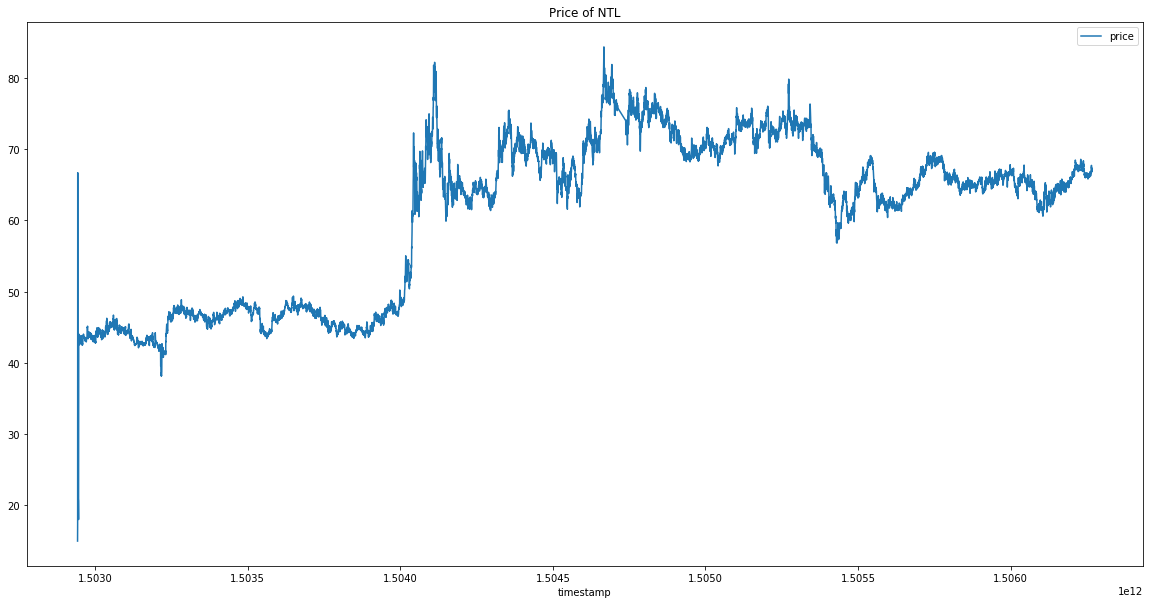

In [20]:
res.plot(y='price', x='timestamp', title="Price of NTL", figsize=(20, 10))

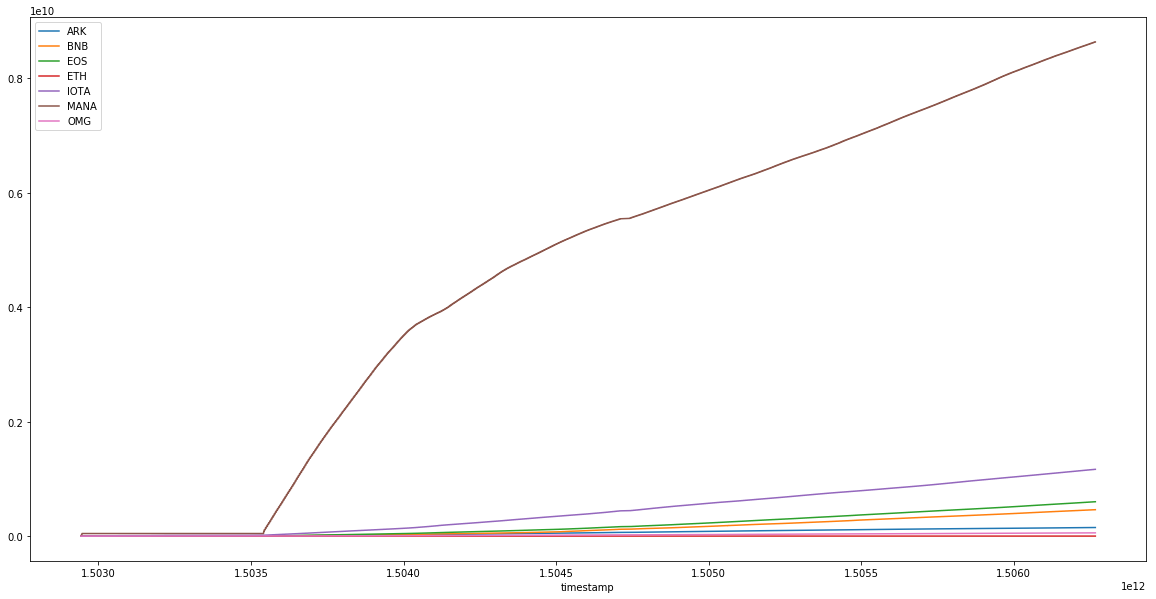

In [21]:
res.drop(columns=['price']).plot(x='timestamp', figsize=(20, 10))

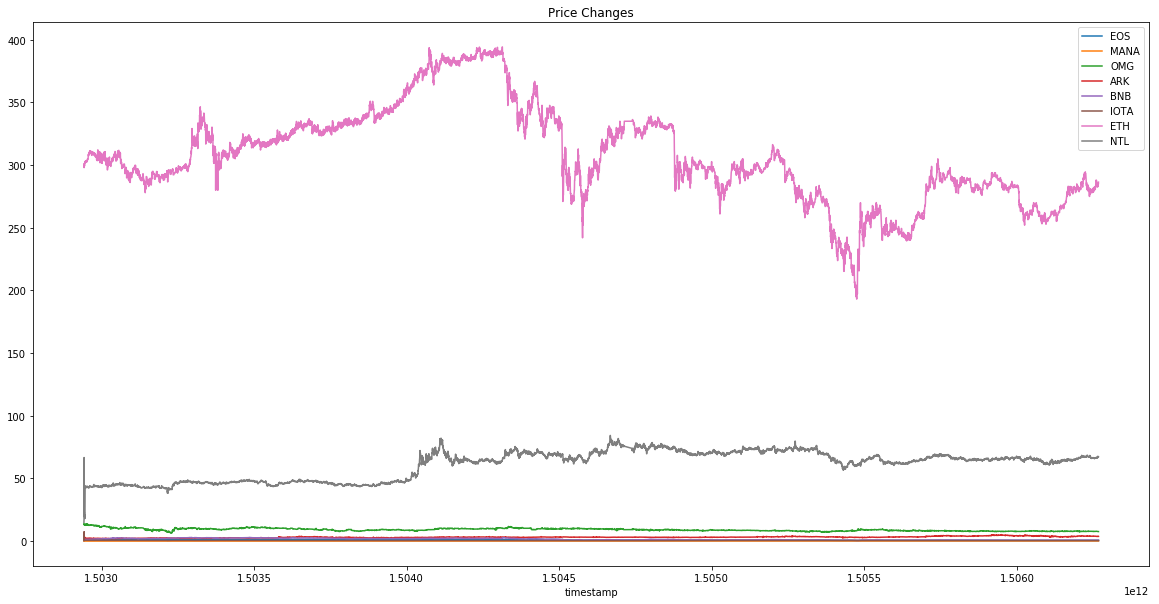

In [22]:
pd.merge(m,
         pd.DataFrame(dict(NTL=res['price'], timestamp=res['timestamp'])),
         on='timestamp').plot(x='timestamp', title="Price Changes", figsize=(20, 10))

In [23]:
m.describe()

,EOS,timestamp,MANA,OMG,ARK,BNB,IOTA,ETH
count,11022.000000,1.102200e+04,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000
mean,1.012053,1.504604e+12,0.065702,9.082596,3.162795,1.521508,0.459192,307.204804
std,0.334062,9.635453e+08,0.037275,1.075108,0.565987,0.709074,0.096970,37.771487
min,0.482895,1.502942e+12,0.013272,6.526780,1.481956,0.503544,0.301110,193.100000
25%,0.679737,1.503767e+12,0.017794,8.205073,2.866501,0.855845,0.408065,283.010000
50%,0.956240,1.504592e+12,0.078798,8.915736,3.124290,1.250860,0.448055,301.225000
75%,1.338159,1.505443e+12,0.097047,9.852690,3.413848,2.201847,0.497293,331.245000
max,1.583040,1.506267e+12,0.140380,13.793944,5.206336,2.956131,7.532500,394.320000
